# Ансамбли. Бустинг.

## ЗАДАНИЕ I. ДОПОЛНИТЕЛЬНОЕ

**Дано**: набор данных из системы поискового антиспама.

**Требуется**: сравнить классификаторы, основанные на алгоритмических композициях, с классическими алгоритмами классификации (SVM, логистическая регрессия) и нейросетями (двуслойный персептрон).

1. Скачать данные и запустить шаблон кода на python:
```
$ python compos.py -h
$ python compos.py -tr spam.train.txt -te spam.test.txt
```
2. Подобрать параметры трёх алгоритмических композиций (RF, Adaboost, GBM), чтобы они превосходили по качеству SVM, логистическую регрессию и двуслойный персептрон.

3. Построить графики качества классификации в зависимости от числа базовых моделей.

4*. Построить графики качества классификации в зависимости от параметров алгоритмов (XGBoost, dart, LightGBM и CatBoost)

### **1.** Пример работы шаблона кода. Качество на SVM, логистической регрессии и двуслойном перцептроне.

In [10]:
!python compos.py -h

usage: compos.py [-h] [-tr TRAIN] [-te TEST] [-t TREES] [-fp FEATURES_PERCENT]

Random Forest Tutorial

optional arguments:
  -h, --help            show this help message and exit
  -tr TRAIN, --train TRAIN
                        Train file name
  -te TEST, --test TEST
                        Test file name
  -t TREES, --trees TREES
                        Number of trees in random forest
  -fp FEATURES_PERCENT, --features_percent FEATURES_PERCENT
                        Percent of features in each tree


In [11]:
!python compos.py -tr spam.train.txt -te spam.test.txt

Build random forest classifier...
Build adaboost classifier...
Build gbm classifier...
Build svm classifier...
Random Forest :
             precision    recall  f1-score   support

        0.0    0.54760   0.87998   0.67509      2033
        1.0    0.96406   0.81578   0.88374      8023

avg / total    0.87986   0.82876   0.84156     10056
final score    0.75583   0.84788   0.77942     10056

AdaBoost :
             precision    recall  f1-score   support

        0.0    0.92398   0.42450   0.58173      2033
        1.0    0.87174   0.99115   0.92762      8023

avg / total    0.88230   0.87659   0.85769     10056
final score    0.89786   0.70782   0.75467     10056

Gradient Boosting Machine :
             precision    recall  f1-score   support

        0.0    0.67793   0.84899   0.75388      2033
        1.0    0.95912   0.89779   0.92744      8023

avg / total    0.90227   0.88793   0.89235     10056
final score    0.81852   0.87339   0.84066     10056

SVM :
             precision  

In [157]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm
from sklearn.metrics import f1_score
#from sklearn.utils.multiclass import unique_labels
#from sklearn.decomposition import PCA


from compos import visualize_data, classification_report


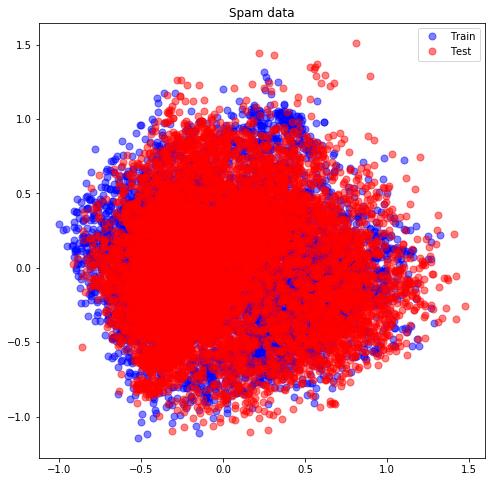

In [159]:
train_data = np.loadtxt("spam.train.txt")
test_data  = np.loadtxt("spam.test.txt")

total_data = np.concatenate(([train_data, test_data]), axis=0)

X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0]

visualize_data(total_data[0::, 1::], len(train_data[:,0]), len(test_data[:,0]))

#number_of_features = len(train_data[0, 1:])

In [28]:
X_train.shape, X_test.shape

((7093, 102), (10056, 102))

In [32]:
number_of_features

102

**Логистическая регрессия (параметры были подобраны в предыдущем дз)**

In [61]:
log_reg = LogisticRegression(random_state=0, C=1.0, l1_ratio=None, penalty='l1',solver='liblinear')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="Logistic regression"))

f1-score=0.9360198874787389
Logistic regression :
             precision    recall  f1-score   support

        0.0    0.68887   0.94638   0.79735      2033
        1.0    0.98499   0.89169   0.93602      8023

avg / total    0.92512   0.90274   0.90798     10056
final score    0.83693   0.91904   0.86668     10056



**SVM**

In [62]:
svm_clf = svm.SVC(kernel="rbf")
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="SVM with rbf kernel"))

f1-score=0.9585241566148487
SVM with rbf kernel :
             precision    recall  f1-score   support

        0.0    0.76980   0.97541   0.86049      2033
        1.0    0.99332   0.92609   0.95852      8023

avg / total    0.94813   0.93606   0.93870     10056
final score    0.88156   0.95075   0.90951     10056



**Двуслойный перцептрон**

In [68]:
import torch
from torch.nn import MSELoss, Linear, Sigmoid, Sequential

NN = Sequential(Linear(102, 100), Sigmoid(), Linear(100, 1))

In [69]:
def train(network, X_train, y_train, n_epoch, lrate):
    losses = []
    loss = MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=lrate)
    for _ in tqdm(range(n_epoch)):
        optimizer.zero_grad()
        out = network(X_train)
        l = loss(out, y_train)
        losses.append(l.detach().numpy())
        l.backward()
        optimizer.step()
    return losses

In [70]:
losses = train(NN, torch.from_numpy(X_train).float(), torch.from_numpy(y_train[:,np.newaxis]).float(), 400, 0.001)
y_pred = NN(torch.from_numpy(X_test).float())
print("f1-score={}".format(f1_score(y_test, (y_pred.detach().numpy() > 0.5).astype(int))))
print(classification_report(y_test, (y_pred.detach().numpy() > 0.5).astype(int), alg_name="Perceptron"))

100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 178.17it/s]

f1-score=0.9389823900188446
Perceptron :
             precision    recall  f1-score   support

        0.0    0.70335   0.93064   0.80119      2033
        1.0    0.98086   0.90054   0.93898      8023

avg / total    0.92475   0.90662   0.91112     10056
final score    0.84210   0.91559   0.87008     10056



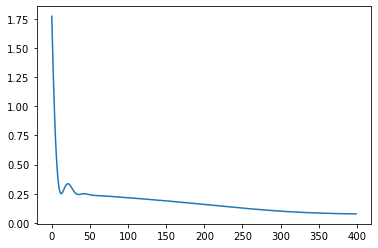

In [71]:
import matplotlib.pyplot as plt
plt.plot(losses)

### **2. и 3.** Подброр параметров для RF, Adaboost, GBM. Графики зависимости качества от числа базовых алгоритмов.

In [6]:
from sklearn.model_selection import GridSearchCV

def find_best_param(params_dict, clf, X, y):

    search = GridSearchCV(clf, param_grid=params, cv=3, n_jobs=-1)
    search.fit(X, y)
    
    return search.best_estimator_

**Random Forest**

In [47]:
params = {
        'n_estimators': range(100, 1051, 50),
        'max_features': np.linspace(0.3, 1.0, 3)
    }
RF_best = find_best_param(params, RandomForestClassifier(), X_train, y_train)

In [48]:
RF_best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [75]:
y_pred = RF_best.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="Random Forest"))

f1-score=0.9648922686945501
Random Forest :
             precision    recall  f1-score   support

        0.0    0.82166   0.92917   0.87211      2033
        1.0    0.98144   0.94890   0.96489      8023

avg / total    0.94913   0.94491   0.94614     10056
final score    0.90155   0.93903   0.91850     10056



In [3]:
def best_num_estim(clf, X_train, y_train, X_test, y_test, min_est, max_est, step):
    num_est = list(range(min_est, max_est, step))
    f1_scores = []
    best_score = 0
    best_n_est = 0
    best_clf = None
    for i in tqdm(range(min_est, max_est, step)):
        clf = clf.set_params(**{'n_estimators': i})
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = f1_score(y_test, y_pred)
        if best_score < score:
            best_score = score
            best_n_est = i
            best_clf = clf
        f1_scores.append(score)
    plt.plot(num_est, f1_scores)
    plt.xlabel('n_estimators')
    plt.ylabel('f1-score')
    plt.title("Tuning of n_estimators parameter")
    return best_clf, f1_scores, best_n_est, best_score

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [12:59<00:00, 33.89s/it]


150

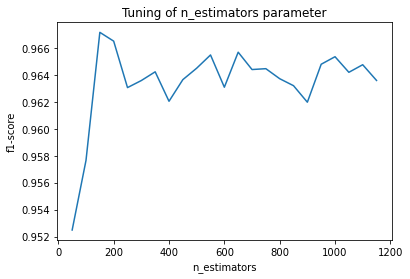

In [93]:
import matplotlib.pyplot as plt
best_RF, f1_scores, best_n_est, best_score = best_num_estim(RandomForestClassifier(max_features=0.3), X_train, y_train, X_test, y_test, 50, 1151, 50)
best_n_est

In [92]:
print("N-estimators={}".format(best_n_est))

N-estimators=250


In [91]:
y_pred = best_RF.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="Random Forest"))

f1-score=0.9656698488967568
Random Forest :
             precision    recall  f1-score   support

        0.0    0.82935   0.92277   0.87357      2033
        1.0    0.97986   0.95189   0.96567      8023

avg / total    0.94943   0.94600   0.94705     10056
final score    0.90461   0.93733   0.91962     10056



**Adaboost**

In [79]:
params = {
        'n_estimators': range(50, 601, 50),
        'learning_rate': np.logspace(-2, 0, 3)
    }
ada_best = find_best_param(params, AdaBoostClassifier(), X_train, y_train)

In [80]:
ada_best

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=600, random_state=None)

In [81]:
y_pred = ada_best.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="Adaboost"))

f1-score=0.9700055204563578
Adaboost :
             precision    recall  f1-score   support

        0.0    0.93468   0.81653   0.87162      2033
        1.0    0.95495   0.98554   0.97001      8023

avg / total    0.95085   0.95137   0.95012     10056
final score    0.94482   0.90103   0.92081     10056



100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [06:05<00:00, 17.41s/it]


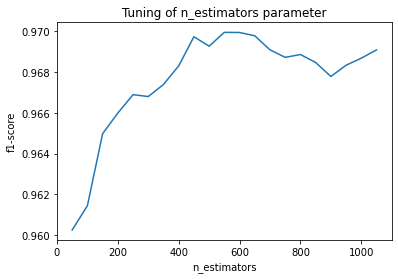

In [83]:
best_ada, f1_scores, best_n_est, best_score = best_num_estim(AdaBoostClassifier(learning_rate=0.1), X_train, y_train, X_test, y_test, 50, 1051, 50)

In [87]:
print("N-estimators={}".format(best_n_est))

N-estimators=550


In [86]:
y_pred = best_ada.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="Adaboost"))

f1-score=0.9690900098911969
Adaboost :
             precision    recall  f1-score   support

        0.0    0.90279   0.84506   0.87297      2033
        1.0    0.96136   0.97694   0.96909      8023

avg / total    0.94952   0.95028   0.94966     10056
final score    0.93207   0.91100   0.92103     10056



**GBM**

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [12:26<00:00, 35.53s/it]


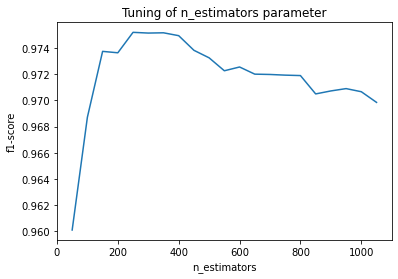

In [94]:
best_gbm, f1_scores, best_n_est, best_score = best_num_estim(GradientBoostingClassifier(), X_train, y_train, X_test, y_test, 50, 1051, 50)

In [95]:
print("N-estimators={}".format(best_n_est))

N-estimators=250


In [96]:
y_pred = best_gbm.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="GBM"))

f1-score=0.9698523892919689
GBM :
             precision    recall  f1-score   support

        0.0    0.87088   0.89572   0.88312      2033
        1.0    0.97338   0.96635   0.96985      8023

avg / total    0.95266   0.95207   0.95232     10056
final score    0.92213   0.93103   0.92649     10056



### xgboost

In [51]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\xgboost\core.py:383: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [61]:
# specify parameters via map
param = {'max_depth': 1, 'learning_rate': 0.1,
         'objective': 'binary:logistic'}

f1_scores = []
best_score = 0
best_n_est = 0
best_clf = None
for i in tqdm(range(50, 1001, 50)):
    clf = xgb.train(param, dtrain, i)
    y_pred =np.where(clf.predict(dtest) < 0.5, 0, 1)
    score = f1_score(y_test, y_pred)
    if best_score < score:
        best_score = score
        best_n_est = i
        best_clf = clf
    f1_scores.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:36<00:00,  1.84s/it]


Text(0.5, 1.0, 'Tuning of n_estimators parameter')

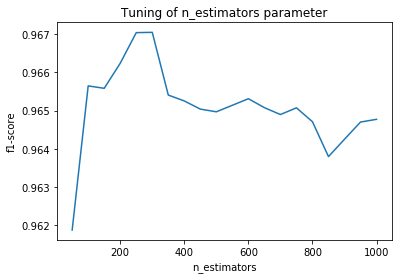

In [62]:
num_est = range(50, 1001, 50)
plt.plot(num_est, f1_scores)
plt.xlabel('n_estimators')
plt.ylabel('f1-score')
plt.title("Tuning of n_estimators parameter")

In [63]:
print("N-estimators={}".format(best_n_est))
y_pred = np.where(best_clf.predict(dtest) < 0.5, 0, 1)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="xgboost"))

N-estimators=300
f1-score=0.9670476653696497
xgboost :
             precision    recall  f1-score   support

        0.0    0.95708   0.76783   0.85207      2033
        1.0    0.94398   0.99128   0.96705      8023

avg / total    0.94663   0.94610   0.94380     10056
final score    0.95053   0.87955   0.90956     10056



### DART

In [64]:
# specify parameters via map
param = {'booster': 'dart',
         'max_depth': 1, 'learning_rate': 0.1,
         'objective': 'binary:logistic',
         'normalize_type': 'tree',
         'rate_drop': 0.1,
         'skip_drop': 0.5}

f1_scores = []
best_score = 0
best_n_est = 0
best_clf = None
for i in tqdm(range(50, 1001, 50)):
    clf = xgb.train(param, dtrain, i)
    y_pred =np.where(clf.predict(dtest) < 0.5, 0, 1)
    score = f1_score(y_test, y_pred)
    if best_score < score:
        best_score = score
        best_n_est = i
        best_clf = clf
    f1_scores.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:02<00:00,  6.14s/it]


Text(0.5, 1.0, 'Tuning of n_estimators parameter')

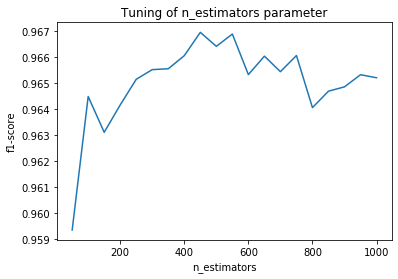

In [65]:
num_est = range(50, 1001, 50)
plt.plot(num_est, f1_scores)
plt.xlabel('n_estimators')
plt.ylabel('f1-score')
plt.title("Tuning of n_estimators parameter")

In [66]:
print("N-estimators={}".format(best_n_est))
y_pred = np.where(best_clf.predict(dtest) < 0.5, 0, 1)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="DART"))

N-estimators=450
f1-score=0.9669567334023002
DART :
             precision    recall  f1-score   support

        0.0    0.95261   0.77127   0.85241      2033
        1.0    0.94471   0.99028   0.96696      8023

avg / total    0.94631   0.94600   0.94380     10056
final score    0.94866   0.88078   0.90968     10056



### catboost

In [35]:
from catboost import CatBoostClassifier, Pool
train_data = Pool(data=X_train,
                  label=y_train
                 )
test_data = Pool(data=X_test,
                  label=y_test
                 )

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Learning rate set to 0.370922
0:	learn: 0.3813814	total: 8.44ms	remaining: 414ms
1:	learn: 0.2638992	total: 16.4ms	remaining: 395ms
2:	learn: 0.1954211	total: 23.8ms	remaining: 373ms
3:	learn: 0.1627364	total: 31ms	remaining: 357ms
4:	learn: 0.1456556	total: 38.6ms	remaining: 348ms
5:	learn: 0.1298618	total: 46.6ms	remaining: 341ms
6:	learn: 0.1161245	total: 53.8ms	remaining: 331ms
7:	learn: 0.1087124	total: 61ms	remaining: 320ms
8:	learn: 0.1027508	total: 68.7ms	remaining: 313ms
9:	learn: 0.0958472	total: 75.6ms	remaining: 302ms
10:	learn: 0.0914906	total: 82.9ms	remaining: 294ms
11:	learn: 0.0855114	total: 90ms	remaining: 285ms
12:	learn: 0.0818254	total: 98.3ms	remaining: 280ms
13:	learn: 0.0787274	total: 105ms	remaining: 271ms
14:	learn: 0.0740368	total: 112ms	remaining: 261ms
15:	learn: 0.0732128	total: 119ms	remaining: 253ms
16:	learn: 0.0699331	total: 126ms	remaining: 245ms
17:	learn: 0.0671107	total: 134ms	remaining: 238ms
18:	learn: 0.0653891	total: 140ms	remaining: 229ms
19:	

  5%|████▏                                                                              | 1/20 [00:00<00:09,  2.01it/s]

Learning rate set to 0.196444
0:	learn: 0.4898777	total: 9.14ms	remaining: 905ms
1:	learn: 0.3672732	total: 17.4ms	remaining: 852ms
2:	learn: 0.2851531	total: 25.1ms	remaining: 812ms
3:	learn: 0.2369995	total: 39.4ms	remaining: 945ms
4:	learn: 0.2079471	total: 46.5ms	remaining: 883ms
5:	learn: 0.1875437	total: 53.8ms	remaining: 842ms
6:	learn: 0.1732903	total: 60.7ms	remaining: 806ms
7:	learn: 0.1619585	total: 68.4ms	remaining: 787ms
8:	learn: 0.1501196	total: 76.3ms	remaining: 771ms
9:	learn: 0.1396386	total: 84.1ms	remaining: 757ms
10:	learn: 0.1317964	total: 91.2ms	remaining: 738ms
11:	learn: 0.1260210	total: 98.3ms	remaining: 721ms
12:	learn: 0.1200659	total: 106ms	remaining: 707ms
13:	learn: 0.1154652	total: 112ms	remaining: 690ms
14:	learn: 0.1106459	total: 120ms	remaining: 679ms
15:	learn: 0.1078403	total: 127ms	remaining: 665ms
16:	learn: 0.1042692	total: 134ms	remaining: 653ms
17:	learn: 0.1008615	total: 140ms	remaining: 640ms
18:	learn: 0.0964218	total: 148ms	remaining: 632ms

 10%|████████▎                                                                          | 2/20 [00:01<00:11,  1.61it/s]

Learning rate set to 0.135445
0:	learn: 0.5427028	total: 7.74ms	remaining: 1.15s
1:	learn: 0.4351796	total: 15.3ms	remaining: 1.13s
2:	learn: 0.3556120	total: 22.4ms	remaining: 1.1s
3:	learn: 0.2978240	total: 29.7ms	remaining: 1.08s
4:	learn: 0.2666948	total: 36.6ms	remaining: 1.06s
5:	learn: 0.2372101	total: 43.7ms	remaining: 1.05s
6:	learn: 0.2165662	total: 50.4ms	remaining: 1.03s
7:	learn: 0.2027526	total: 57.3ms	remaining: 1.02s
8:	learn: 0.1875468	total: 64.4ms	remaining: 1.01s
9:	learn: 0.1746849	total: 71.4ms	remaining: 1000ms
10:	learn: 0.1639032	total: 78.4ms	remaining: 990ms
11:	learn: 0.1536940	total: 85ms	remaining: 977ms
12:	learn: 0.1477366	total: 91.6ms	remaining: 966ms
13:	learn: 0.1401741	total: 98.4ms	remaining: 955ms
14:	learn: 0.1339800	total: 105ms	remaining: 946ms
15:	learn: 0.1294766	total: 112ms	remaining: 937ms
16:	learn: 0.1265097	total: 118ms	remaining: 926ms
17:	learn: 0.1226559	total: 125ms	remaining: 920ms
18:	learn: 0.1187631	total: 132ms	remaining: 911ms

 15%|████████████▍                                                                      | 3/20 [00:02<00:13,  1.25it/s]

Learning rate set to 0.104038
0:	learn: 0.5733895	total: 8.58ms	remaining: 1.71s
1:	learn: 0.4740448	total: 15.9ms	remaining: 1.57s
2:	learn: 0.4104541	total: 22.9ms	remaining: 1.5s
3:	learn: 0.3539700	total: 30.3ms	remaining: 1.49s
4:	learn: 0.3102240	total: 37.7ms	remaining: 1.47s
5:	learn: 0.2781873	total: 45ms	remaining: 1.45s
6:	learn: 0.2545618	total: 52.2ms	remaining: 1.44s
7:	learn: 0.2322973	total: 59.3ms	remaining: 1.42s
8:	learn: 0.2183902	total: 67.5ms	remaining: 1.43s
9:	learn: 0.2051473	total: 74.6ms	remaining: 1.42s
10:	learn: 0.1937892	total: 81.3ms	remaining: 1.4s
11:	learn: 0.1838677	total: 87.9ms	remaining: 1.38s
12:	learn: 0.1758932	total: 94.6ms	remaining: 1.36s
13:	learn: 0.1668659	total: 101ms	remaining: 1.34s
14:	learn: 0.1601168	total: 108ms	remaining: 1.33s
15:	learn: 0.1530561	total: 115ms	remaining: 1.32s
16:	learn: 0.1484972	total: 121ms	remaining: 1.3s
17:	learn: 0.1439140	total: 128ms	remaining: 1.29s
18:	learn: 0.1390884	total: 135ms	remaining: 1.28s
19:

184:	learn: 0.0246569	total: 1.26s	remaining: 102ms
185:	learn: 0.0244575	total: 1.26s	remaining: 95.3ms
186:	learn: 0.0244418	total: 1.27s	remaining: 88.5ms
187:	learn: 0.0242677	total: 1.28s	remaining: 81.6ms
188:	learn: 0.0241732	total: 1.28s	remaining: 74.8ms
189:	learn: 0.0239711	total: 1.29s	remaining: 68ms
190:	learn: 0.0236873	total: 1.3s	remaining: 61.2ms
191:	learn: 0.0234010	total: 1.3s	remaining: 54.4ms
192:	learn: 0.0232101	total: 1.31s	remaining: 47.6ms
193:	learn: 0.0229877	total: 1.32s	remaining: 40.8ms
194:	learn: 0.0227655	total: 1.32s	remaining: 34ms
195:	learn: 0.0226698	total: 1.33s	remaining: 27.2ms
196:	learn: 0.0226064	total: 1.34s	remaining: 20.4ms
197:	learn: 0.0224040	total: 1.34s	remaining: 13.6ms
198:	learn: 0.0222692	total: 1.35s	remaining: 6.79ms
199:	learn: 0.0222515	total: 1.36s	remaining: 0us


 20%|████████████████▌                                                                  | 4/20 [00:04<00:16,  1.03s/it]

Learning rate set to 0.084787
0:	learn: 0.5934246	total: 7.71ms	remaining: 1.92s
1:	learn: 0.5054412	total: 14.6ms	remaining: 1.81s
2:	learn: 0.4308145	total: 21.5ms	remaining: 1.77s
3:	learn: 0.3775730	total: 28.4ms	remaining: 1.74s
4:	learn: 0.3435878	total: 35.3ms	remaining: 1.73s
5:	learn: 0.3089192	total: 42.3ms	remaining: 1.72s
6:	learn: 0.2836801	total: 49.2ms	remaining: 1.71s
7:	learn: 0.2613223	total: 56ms	remaining: 1.69s
8:	learn: 0.2469275	total: 62.7ms	remaining: 1.68s
9:	learn: 0.2303428	total: 69.6ms	remaining: 1.67s
10:	learn: 0.2171665	total: 76.3ms	remaining: 1.66s
11:	learn: 0.2056498	total: 83ms	remaining: 1.65s
12:	learn: 0.1972092	total: 89.7ms	remaining: 1.63s
13:	learn: 0.1865320	total: 96.3ms	remaining: 1.62s
14:	learn: 0.1786606	total: 103ms	remaining: 1.61s
15:	learn: 0.1745025	total: 109ms	remaining: 1.6s
16:	learn: 0.1680183	total: 116ms	remaining: 1.59s
17:	learn: 0.1626172	total: 123ms	remaining: 1.58s
18:	learn: 0.1578290	total: 129ms	remaining: 1.57s
19

160:	learn: 0.0362071	total: 1.08s	remaining: 596ms
161:	learn: 0.0361046	total: 1.08s	remaining: 589ms
162:	learn: 0.0357800	total: 1.09s	remaining: 583ms
163:	learn: 0.0356765	total: 1.1s	remaining: 576ms
164:	learn: 0.0354610	total: 1.1s	remaining: 570ms
165:	learn: 0.0354140	total: 1.11s	remaining: 563ms
166:	learn: 0.0351235	total: 1.12s	remaining: 556ms
167:	learn: 0.0347797	total: 1.13s	remaining: 549ms
168:	learn: 0.0344790	total: 1.13s	remaining: 543ms
169:	learn: 0.0343242	total: 1.14s	remaining: 536ms
170:	learn: 0.0343019	total: 1.15s	remaining: 529ms
171:	learn: 0.0340766	total: 1.15s	remaining: 522ms
172:	learn: 0.0337371	total: 1.16s	remaining: 516ms
173:	learn: 0.0334025	total: 1.16s	remaining: 509ms
174:	learn: 0.0332490	total: 1.17s	remaining: 502ms
175:	learn: 0.0330907	total: 1.18s	remaining: 495ms
176:	learn: 0.0328110	total: 1.18s	remaining: 489ms
177:	learn: 0.0326132	total: 1.19s	remaining: 482ms
178:	learn: 0.0325009	total: 1.2s	remaining: 475ms
179:	learn: 0.0

 25%|████████████████████▊                                                              | 5/20 [00:06<00:19,  1.28s/it]

241:	learn: 0.0221690	total: 1.61s	remaining: 53.4ms
242:	learn: 0.0220970	total: 1.62s	remaining: 46.7ms
243:	learn: 0.0218866	total: 1.63s	remaining: 40.1ms
244:	learn: 0.0216792	total: 1.64s	remaining: 33.4ms
245:	learn: 0.0214858	total: 1.64s	remaining: 26.7ms
246:	learn: 0.0212070	total: 1.65s	remaining: 20ms
247:	learn: 0.0210638	total: 1.66s	remaining: 13.4ms
248:	learn: 0.0207746	total: 1.66s	remaining: 6.68ms
249:	learn: 0.0207117	total: 1.67s	remaining: 0us
Learning rate set to 0.071733
0:	learn: 0.6075510	total: 9.57ms	remaining: 2.86s
1:	learn: 0.5288442	total: 16.5ms	remaining: 2.46s
2:	learn: 0.4595227	total: 23.3ms	remaining: 2.31s
3:	learn: 0.4101056	total: 30.3ms	remaining: 2.24s
4:	learn: 0.3764143	total: 37.2ms	remaining: 2.2s
5:	learn: 0.3448813	total: 44.1ms	remaining: 2.16s
6:	learn: 0.3183401	total: 51.1ms	remaining: 2.14s
7:	learn: 0.2967371	total: 58ms	remaining: 2.12s
8:	learn: 0.2746924	total: 65ms	remaining: 2.1s
9:	learn: 0.2542238	total: 72ms	remaining: 2.

161:	learn: 0.0418450	total: 1.09s	remaining: 932ms
162:	learn: 0.0417126	total: 1.1s	remaining: 926ms
163:	learn: 0.0415083	total: 1.11s	remaining: 919ms
164:	learn: 0.0411071	total: 1.11s	remaining: 912ms
165:	learn: 0.0408460	total: 1.12s	remaining: 906ms
166:	learn: 0.0406608	total: 1.13s	remaining: 899ms
167:	learn: 0.0404546	total: 1.14s	remaining: 892ms
168:	learn: 0.0402770	total: 1.14s	remaining: 885ms
169:	learn: 0.0400575	total: 1.15s	remaining: 878ms
170:	learn: 0.0398857	total: 1.15s	remaining: 871ms
171:	learn: 0.0396329	total: 1.16s	remaining: 864ms
172:	learn: 0.0393473	total: 1.17s	remaining: 858ms
173:	learn: 0.0393253	total: 1.17s	remaining: 851ms
174:	learn: 0.0389125	total: 1.18s	remaining: 844ms
175:	learn: 0.0385824	total: 1.19s	remaining: 837ms
176:	learn: 0.0384510	total: 1.19s	remaining: 830ms
177:	learn: 0.0382296	total: 1.2s	remaining: 823ms
178:	learn: 0.0380004	total: 1.21s	remaining: 816ms
179:	learn: 0.0376544	total: 1.21s	remaining: 810ms
180:	learn: 0.

 30%|████████████████████████▉                                                          | 6/20 [00:08<00:22,  1.58s/it]

289:	learn: 0.0216321	total: 1.98s	remaining: 68.4ms
290:	learn: 0.0215470	total: 1.99s	remaining: 61.6ms
291:	learn: 0.0214860	total: 2s	remaining: 54.8ms
292:	learn: 0.0214076	total: 2s	remaining: 47.9ms
293:	learn: 0.0213067	total: 2.01s	remaining: 41.1ms
294:	learn: 0.0212067	total: 2.02s	remaining: 34.2ms
295:	learn: 0.0212013	total: 2.02s	remaining: 27.4ms
296:	learn: 0.0210144	total: 2.03s	remaining: 20.5ms
297:	learn: 0.0209003	total: 2.04s	remaining: 13.7ms
298:	learn: 0.0208311	total: 2.04s	remaining: 6.84ms
299:	learn: 0.0207549	total: 2.05s	remaining: 0us
Learning rate set to 0.062277
0:	learn: 0.6180597	total: 7.79ms	remaining: 2.72s
1:	learn: 0.5494708	total: 15.2ms	remaining: 2.64s
2:	learn: 0.4855798	total: 22ms	remaining: 2.54s
3:	learn: 0.4391693	total: 29.2ms	remaining: 2.52s
4:	learn: 0.4055748	total: 36ms	remaining: 2.48s
5:	learn: 0.3716654	total: 42.8ms	remaining: 2.45s
6:	learn: 0.3466404	total: 49.5ms	remaining: 2.43s
7:	learn: 0.3225234	total: 56.2ms	remaining

159:	learn: 0.0496891	total: 1.08s	remaining: 1.28s
160:	learn: 0.0494952	total: 1.09s	remaining: 1.28s
161:	learn: 0.0493469	total: 1.1s	remaining: 1.27s
162:	learn: 0.0491518	total: 1.1s	remaining: 1.26s
163:	learn: 0.0488145	total: 1.11s	remaining: 1.26s
164:	learn: 0.0487690	total: 1.12s	remaining: 1.25s
165:	learn: 0.0486134	total: 1.12s	remaining: 1.24s
166:	learn: 0.0483386	total: 1.13s	remaining: 1.24s
167:	learn: 0.0478954	total: 1.14s	remaining: 1.23s
168:	learn: 0.0474345	total: 1.14s	remaining: 1.22s
169:	learn: 0.0472739	total: 1.15s	remaining: 1.22s
170:	learn: 0.0470127	total: 1.16s	remaining: 1.21s
171:	learn: 0.0468027	total: 1.16s	remaining: 1.2s
172:	learn: 0.0462403	total: 1.17s	remaining: 1.2s
173:	learn: 0.0460196	total: 1.18s	remaining: 1.19s
174:	learn: 0.0458155	total: 1.18s	remaining: 1.18s
175:	learn: 0.0456418	total: 1.19s	remaining: 1.18s
176:	learn: 0.0454643	total: 1.2s	remaining: 1.17s
177:	learn: 0.0452042	total: 1.2s	remaining: 1.16s
178:	learn: 0.0450

322:	learn: 0.0233184	total: 2.16s	remaining: 181ms
323:	learn: 0.0233050	total: 2.17s	remaining: 174ms
324:	learn: 0.0231993	total: 2.18s	remaining: 168ms
325:	learn: 0.0229820	total: 2.19s	remaining: 161ms
326:	learn: 0.0229412	total: 2.19s	remaining: 154ms
327:	learn: 0.0228648	total: 2.2s	remaining: 147ms
328:	learn: 0.0227121	total: 2.21s	remaining: 141ms
329:	learn: 0.0226913	total: 2.21s	remaining: 134ms
330:	learn: 0.0225226	total: 2.22s	remaining: 127ms
331:	learn: 0.0225000	total: 2.22s	remaining: 121ms
332:	learn: 0.0223990	total: 2.23s	remaining: 114ms
333:	learn: 0.0223114	total: 2.24s	remaining: 107ms
334:	learn: 0.0222025	total: 2.24s	remaining: 101ms
335:	learn: 0.0221415	total: 2.25s	remaining: 93.8ms
336:	learn: 0.0220627	total: 2.26s	remaining: 87.1ms
337:	learn: 0.0219610	total: 2.26s	remaining: 80.4ms
338:	learn: 0.0218251	total: 2.27s	remaining: 73.7ms
339:	learn: 0.0217366	total: 2.28s	remaining: 67ms
340:	learn: 0.0216912	total: 2.28s	remaining: 60.3ms
341:	lear

 35%|█████████████████████████████                                                      | 7/20 [00:10<00:24,  1.88s/it]

349:	learn: 0.0209437	total: 2.34s	remaining: 0us
Learning rate set to 0.0551
0:	learn: 0.6261914	total: 8ms	remaining: 3.19s
1:	learn: 0.5637036	total: 15.1ms	remaining: 3.01s
2:	learn: 0.5041200	total: 21.9ms	remaining: 2.9s
3:	learn: 0.4600161	total: 28.9ms	remaining: 2.86s
4:	learn: 0.4274101	total: 35.6ms	remaining: 2.81s
5:	learn: 0.3891023	total: 42.3ms	remaining: 2.78s
6:	learn: 0.3645401	total: 49.3ms	remaining: 2.77s
7:	learn: 0.3410216	total: 56.4ms	remaining: 2.76s
8:	learn: 0.3206500	total: 63.7ms	remaining: 2.77s
9:	learn: 0.2996509	total: 70.6ms	remaining: 2.75s
10:	learn: 0.2846231	total: 77.3ms	remaining: 2.73s
11:	learn: 0.2695613	total: 84.1ms	remaining: 2.72s
12:	learn: 0.2571442	total: 90.8ms	remaining: 2.7s
13:	learn: 0.2450708	total: 97.6ms	remaining: 2.69s
14:	learn: 0.2349828	total: 104ms	remaining: 2.68s
15:	learn: 0.2275877	total: 111ms	remaining: 2.66s
16:	learn: 0.2211715	total: 118ms	remaining: 2.65s
17:	learn: 0.2141904	total: 124ms	remaining: 2.64s
18:	l

165:	learn: 0.0521950	total: 1.12s	remaining: 1.58s
166:	learn: 0.0521025	total: 1.13s	remaining: 1.57s
167:	learn: 0.0518923	total: 1.14s	remaining: 1.57s
168:	learn: 0.0512590	total: 1.14s	remaining: 1.56s
169:	learn: 0.0511810	total: 1.15s	remaining: 1.55s
170:	learn: 0.0508577	total: 1.16s	remaining: 1.55s
171:	learn: 0.0505486	total: 1.16s	remaining: 1.54s
172:	learn: 0.0501842	total: 1.17s	remaining: 1.53s
173:	learn: 0.0498839	total: 1.18s	remaining: 1.53s
174:	learn: 0.0496727	total: 1.18s	remaining: 1.52s
175:	learn: 0.0493345	total: 1.19s	remaining: 1.51s
176:	learn: 0.0490350	total: 1.2s	remaining: 1.5s
177:	learn: 0.0488321	total: 1.2s	remaining: 1.5s
178:	learn: 0.0487178	total: 1.21s	remaining: 1.49s
179:	learn: 0.0485020	total: 1.21s	remaining: 1.48s
180:	learn: 0.0482497	total: 1.22s	remaining: 1.48s
181:	learn: 0.0479721	total: 1.23s	remaining: 1.47s
182:	learn: 0.0476625	total: 1.23s	remaining: 1.46s
183:	learn: 0.0475706	total: 1.24s	remaining: 1.46s
184:	learn: 0.04

328:	learn: 0.0256375	total: 2.2s	remaining: 475ms
329:	learn: 0.0256142	total: 2.21s	remaining: 469ms
330:	learn: 0.0254843	total: 2.22s	remaining: 462ms
331:	learn: 0.0254006	total: 2.22s	remaining: 455ms
332:	learn: 0.0253132	total: 2.23s	remaining: 449ms
333:	learn: 0.0251508	total: 2.24s	remaining: 442ms
334:	learn: 0.0251100	total: 2.24s	remaining: 435ms
335:	learn: 0.0250082	total: 2.25s	remaining: 429ms
336:	learn: 0.0249847	total: 2.26s	remaining: 422ms
337:	learn: 0.0248762	total: 2.26s	remaining: 415ms
338:	learn: 0.0247659	total: 2.27s	remaining: 408ms
339:	learn: 0.0246742	total: 2.28s	remaining: 402ms
340:	learn: 0.0246673	total: 2.28s	remaining: 395ms
341:	learn: 0.0245977	total: 2.29s	remaining: 388ms
342:	learn: 0.0244510	total: 2.29s	remaining: 382ms
343:	learn: 0.0243604	total: 2.3s	remaining: 375ms
344:	learn: 0.0242301	total: 2.31s	remaining: 368ms
345:	learn: 0.0241082	total: 2.31s	remaining: 361ms
346:	learn: 0.0240311	total: 2.32s	remaining: 355ms
347:	learn: 0.

 40%|█████████████████████████████████▏                                                 | 8/20 [00:13<00:26,  2.19s/it]

Learning rate set to 0.049459
0:	learn: 0.6326775	total: 8ms	remaining: 3.59s
1:	learn: 0.5752900	total: 14.9ms	remaining: 3.33s
2:	learn: 0.5195597	total: 21.8ms	remaining: 3.25s
3:	learn: 0.4769993	total: 28.6ms	remaining: 3.19s
4:	learn: 0.4455383	total: 35.3ms	remaining: 3.14s
5:	learn: 0.4082603	total: 42.2ms	remaining: 3.12s
6:	learn: 0.3839511	total: 48.9ms	remaining: 3.1s
7:	learn: 0.3581141	total: 55.7ms	remaining: 3.08s
8:	learn: 0.3377262	total: 62.3ms	remaining: 3.05s
9:	learn: 0.3181763	total: 69.2ms	remaining: 3.05s
10:	learn: 0.3015359	total: 75.9ms	remaining: 3.03s
11:	learn: 0.2861406	total: 82.7ms	remaining: 3.02s
12:	learn: 0.2727897	total: 89.4ms	remaining: 3.01s
13:	learn: 0.2588436	total: 96.1ms	remaining: 2.99s
14:	learn: 0.2494592	total: 103ms	remaining: 2.98s
15:	learn: 0.2416581	total: 109ms	remaining: 2.97s
16:	learn: 0.2349061	total: 116ms	remaining: 2.96s
17:	learn: 0.2279992	total: 123ms	remaining: 2.95s
18:	learn: 0.2206924	total: 130ms	remaining: 2.94s
1

185:	learn: 0.0527676	total: 1.25s	remaining: 1.78s
186:	learn: 0.0526324	total: 1.26s	remaining: 1.77s
187:	learn: 0.0523222	total: 1.27s	remaining: 1.76s
188:	learn: 0.0518873	total: 1.27s	remaining: 1.76s
189:	learn: 0.0516844	total: 1.28s	remaining: 1.75s
190:	learn: 0.0514958	total: 1.29s	remaining: 1.74s
191:	learn: 0.0512076	total: 1.29s	remaining: 1.74s
192:	learn: 0.0510840	total: 1.3s	remaining: 1.73s
193:	learn: 0.0509988	total: 1.31s	remaining: 1.72s
194:	learn: 0.0507655	total: 1.31s	remaining: 1.72s
195:	learn: 0.0506479	total: 1.32s	remaining: 1.71s
196:	learn: 0.0504558	total: 1.32s	remaining: 1.7s
197:	learn: 0.0502684	total: 1.33s	remaining: 1.7s
198:	learn: 0.0500923	total: 1.34s	remaining: 1.69s
199:	learn: 0.0497674	total: 1.34s	remaining: 1.68s
200:	learn: 0.0496445	total: 1.35s	remaining: 1.67s
201:	learn: 0.0495381	total: 1.36s	remaining: 1.67s
202:	learn: 0.0493565	total: 1.36s	remaining: 1.66s
203:	learn: 0.0491336	total: 1.37s	remaining: 1.65s
204:	learn: 0.0

349:	learn: 0.0283511	total: 2.34s	remaining: 669ms
350:	learn: 0.0282500	total: 2.35s	remaining: 662ms
351:	learn: 0.0282128	total: 2.35s	remaining: 655ms
352:	learn: 0.0280938	total: 2.36s	remaining: 649ms
353:	learn: 0.0280214	total: 2.37s	remaining: 642ms
354:	learn: 0.0278725	total: 2.37s	remaining: 635ms
355:	learn: 0.0278135	total: 2.38s	remaining: 629ms
356:	learn: 0.0277619	total: 2.39s	remaining: 622ms
357:	learn: 0.0276687	total: 2.39s	remaining: 615ms
358:	learn: 0.0276550	total: 2.4s	remaining: 609ms
359:	learn: 0.0274825	total: 2.41s	remaining: 602ms
360:	learn: 0.0274344	total: 2.41s	remaining: 595ms
361:	learn: 0.0273379	total: 2.42s	remaining: 588ms
362:	learn: 0.0271677	total: 2.43s	remaining: 582ms
363:	learn: 0.0271025	total: 2.43s	remaining: 575ms
364:	learn: 0.0268783	total: 2.44s	remaining: 568ms
365:	learn: 0.0268447	total: 2.45s	remaining: 562ms
366:	learn: 0.0267442	total: 2.45s	remaining: 555ms
367:	learn: 0.0265519	total: 2.46s	remaining: 548ms
368:	learn: 0

 45%|█████████████████████████████████████▎                                             | 9/20 [00:17<00:27,  2.52s/it]

Learning rate set to 0.044904
0:	learn: 0.6379759	total: 8.22ms	remaining: 4.1s
1:	learn: 0.5849085	total: 15ms	remaining: 3.74s
2:	learn: 0.5326104	total: 22ms	remaining: 3.65s
3:	learn: 0.4921400	total: 28.8ms	remaining: 3.57s
4:	learn: 0.4618231	total: 35.6ms	remaining: 3.53s
5:	learn: 0.4281974	total: 42.5ms	remaining: 3.5s
6:	learn: 0.4040746	total: 49.2ms	remaining: 3.47s
7:	learn: 0.3778125	total: 56ms	remaining: 3.44s
8:	learn: 0.3592676	total: 62.7ms	remaining: 3.42s
9:	learn: 0.3388651	total: 69.4ms	remaining: 3.4s
10:	learn: 0.3230189	total: 76ms	remaining: 3.38s
11:	learn: 0.3067677	total: 82.7ms	remaining: 3.37s
12:	learn: 0.2919564	total: 89.5ms	remaining: 3.35s
13:	learn: 0.2783706	total: 96.7ms	remaining: 3.36s
14:	learn: 0.2669638	total: 103ms	remaining: 3.34s
15:	learn: 0.2569551	total: 110ms	remaining: 3.33s
16:	learn: 0.2492577	total: 117ms	remaining: 3.31s
17:	learn: 0.2416572	total: 123ms	remaining: 3.3s
18:	learn: 0.2337103	total: 130ms	remaining: 3.29s
19:	learn

161:	learn: 0.0619378	total: 1.09s	remaining: 2.28s
162:	learn: 0.0616016	total: 1.1s	remaining: 2.27s
163:	learn: 0.0613214	total: 1.11s	remaining: 2.27s
164:	learn: 0.0609639	total: 1.11s	remaining: 2.26s
165:	learn: 0.0607384	total: 1.12s	remaining: 2.25s
166:	learn: 0.0604990	total: 1.13s	remaining: 2.25s
167:	learn: 0.0603055	total: 1.13s	remaining: 2.24s
168:	learn: 0.0600286	total: 1.14s	remaining: 2.23s
169:	learn: 0.0599526	total: 1.15s	remaining: 2.23s
170:	learn: 0.0596127	total: 1.15s	remaining: 2.22s
171:	learn: 0.0594934	total: 1.16s	remaining: 2.21s
172:	learn: 0.0592640	total: 1.17s	remaining: 2.2s
173:	learn: 0.0590746	total: 1.17s	remaining: 2.2s
174:	learn: 0.0589164	total: 1.18s	remaining: 2.19s
175:	learn: 0.0586450	total: 1.19s	remaining: 2.18s
176:	learn: 0.0582781	total: 1.19s	remaining: 2.18s
177:	learn: 0.0579626	total: 1.2s	remaining: 2.17s
178:	learn: 0.0577325	total: 1.21s	remaining: 2.16s
179:	learn: 0.0574859	total: 1.21s	remaining: 2.15s
180:	learn: 0.05

323:	learn: 0.0341610	total: 2.16s	remaining: 1.18s
324:	learn: 0.0339910	total: 2.17s	remaining: 1.17s
325:	learn: 0.0338814	total: 2.18s	remaining: 1.16s
326:	learn: 0.0338342	total: 2.18s	remaining: 1.16s
327:	learn: 0.0336385	total: 2.19s	remaining: 1.15s
328:	learn: 0.0333609	total: 2.2s	remaining: 1.14s
329:	learn: 0.0333504	total: 2.21s	remaining: 1.14s
330:	learn: 0.0332806	total: 2.21s	remaining: 1.13s
331:	learn: 0.0332643	total: 2.22s	remaining: 1.12s
332:	learn: 0.0331458	total: 2.22s	remaining: 1.11s
333:	learn: 0.0329859	total: 2.23s	remaining: 1.11s
334:	learn: 0.0329287	total: 2.24s	remaining: 1.1s
335:	learn: 0.0327914	total: 2.24s	remaining: 1.09s
336:	learn: 0.0327773	total: 2.25s	remaining: 1.09s
337:	learn: 0.0326875	total: 2.26s	remaining: 1.08s
338:	learn: 0.0325933	total: 2.26s	remaining: 1.07s
339:	learn: 0.0324617	total: 2.27s	remaining: 1.07s
340:	learn: 0.0324533	total: 2.28s	remaining: 1.06s
341:	learn: 0.0322380	total: 2.28s	remaining: 1.05s
342:	learn: 0.

486:	learn: 0.0207923	total: 3.25s	remaining: 86.6ms
487:	learn: 0.0207126	total: 3.25s	remaining: 80ms
488:	learn: 0.0206863	total: 3.26s	remaining: 73.3ms
489:	learn: 0.0206449	total: 3.27s	remaining: 66.6ms
490:	learn: 0.0205648	total: 3.27s	remaining: 60ms
491:	learn: 0.0204890	total: 3.28s	remaining: 53.3ms
492:	learn: 0.0204803	total: 3.29s	remaining: 46.6ms
493:	learn: 0.0204170	total: 3.29s	remaining: 40ms
494:	learn: 0.0203329	total: 3.3s	remaining: 33.3ms
495:	learn: 0.0202831	total: 3.31s	remaining: 26.7ms
496:	learn: 0.0202222	total: 3.31s	remaining: 20ms
497:	learn: 0.0202186	total: 3.32s	remaining: 13.3ms
498:	learn: 0.0201812	total: 3.33s	remaining: 6.66ms
499:	learn: 0.0201095	total: 3.33s	remaining: 0us


 50%|█████████████████████████████████████████                                         | 10/20 [00:20<00:28,  2.85s/it]

Learning rate set to 0.041146
0:	learn: 0.6423884	total: 7.68ms	remaining: 4.22s
1:	learn: 0.5930239	total: 14.6ms	remaining: 4s
2:	learn: 0.5437845	total: 21.5ms	remaining: 3.91s
3:	learn: 0.5005008	total: 28.2ms	remaining: 3.85s
4:	learn: 0.4688426	total: 35.2ms	remaining: 3.83s
5:	learn: 0.4415171	total: 42ms	remaining: 3.81s
6:	learn: 0.4132871	total: 49.1ms	remaining: 3.81s
7:	learn: 0.3905392	total: 56ms	remaining: 3.79s
8:	learn: 0.3708125	total: 62.8ms	remaining: 3.78s
9:	learn: 0.3475937	total: 69.7ms	remaining: 3.77s
10:	learn: 0.3303980	total: 76.3ms	remaining: 3.74s
11:	learn: 0.3148306	total: 83.4ms	remaining: 3.74s
12:	learn: 0.2989294	total: 90.2ms	remaining: 3.73s
13:	learn: 0.2840842	total: 97.2ms	remaining: 3.72s
14:	learn: 0.2737840	total: 104ms	remaining: 3.71s
15:	learn: 0.2620886	total: 111ms	remaining: 3.69s
16:	learn: 0.2550912	total: 117ms	remaining: 3.68s
17:	learn: 0.2475042	total: 124ms	remaining: 3.67s
18:	learn: 0.2395197	total: 131ms	remaining: 3.65s
19:	

186:	learn: 0.0595131	total: 1.27s	remaining: 2.46s
187:	learn: 0.0592333	total: 1.27s	remaining: 2.46s
188:	learn: 0.0590618	total: 1.28s	remaining: 2.45s
189:	learn: 0.0588252	total: 1.29s	remaining: 2.44s
190:	learn: 0.0585119	total: 1.3s	remaining: 2.44s
191:	learn: 0.0581331	total: 1.3s	remaining: 2.43s
192:	learn: 0.0578946	total: 1.31s	remaining: 2.42s
193:	learn: 0.0575807	total: 1.32s	remaining: 2.42s
194:	learn: 0.0573592	total: 1.32s	remaining: 2.41s
195:	learn: 0.0571919	total: 1.33s	remaining: 2.4s
196:	learn: 0.0569952	total: 1.33s	remaining: 2.39s
197:	learn: 0.0566501	total: 1.34s	remaining: 2.39s
198:	learn: 0.0564990	total: 1.35s	remaining: 2.38s
199:	learn: 0.0563439	total: 1.35s	remaining: 2.37s
200:	learn: 0.0560227	total: 1.36s	remaining: 2.37s
201:	learn: 0.0557862	total: 1.37s	remaining: 2.36s
202:	learn: 0.0555672	total: 1.38s	remaining: 2.35s
203:	learn: 0.0553217	total: 1.38s	remaining: 2.34s
204:	learn: 0.0551628	total: 1.39s	remaining: 2.34s
205:	learn: 0.0

346:	learn: 0.0340669	total: 2.33s	remaining: 1.37s
347:	learn: 0.0340096	total: 2.34s	remaining: 1.36s
348:	learn: 0.0339066	total: 2.35s	remaining: 1.35s
349:	learn: 0.0338291	total: 2.36s	remaining: 1.35s
350:	learn: 0.0336891	total: 2.36s	remaining: 1.34s
351:	learn: 0.0336104	total: 2.37s	remaining: 1.33s
352:	learn: 0.0334997	total: 2.38s	remaining: 1.33s
353:	learn: 0.0333504	total: 2.38s	remaining: 1.32s
354:	learn: 0.0332789	total: 2.39s	remaining: 1.31s
355:	learn: 0.0332145	total: 2.4s	remaining: 1.3s
356:	learn: 0.0332014	total: 2.4s	remaining: 1.3s
357:	learn: 0.0330677	total: 2.41s	remaining: 1.29s
358:	learn: 0.0329763	total: 2.42s	remaining: 1.28s
359:	learn: 0.0328261	total: 2.42s	remaining: 1.28s
360:	learn: 0.0327602	total: 2.43s	remaining: 1.27s
361:	learn: 0.0327021	total: 2.44s	remaining: 1.26s
362:	learn: 0.0326392	total: 2.44s	remaining: 1.26s
363:	learn: 0.0324909	total: 2.45s	remaining: 1.25s
364:	learn: 0.0324248	total: 2.46s	remaining: 1.24s
365:	learn: 0.03

509:	learn: 0.0218796	total: 3.42s	remaining: 268ms
510:	learn: 0.0218498	total: 3.43s	remaining: 262ms
511:	learn: 0.0217405	total: 3.44s	remaining: 255ms
512:	learn: 0.0217147	total: 3.44s	remaining: 248ms
513:	learn: 0.0216453	total: 3.45s	remaining: 242ms
514:	learn: 0.0215674	total: 3.46s	remaining: 235ms
515:	learn: 0.0215251	total: 3.46s	remaining: 228ms
516:	learn: 0.0214938	total: 3.47s	remaining: 221ms
517:	learn: 0.0214494	total: 3.47s	remaining: 215ms
518:	learn: 0.0214082	total: 3.48s	remaining: 208ms
519:	learn: 0.0213359	total: 3.49s	remaining: 201ms
520:	learn: 0.0212461	total: 3.49s	remaining: 195ms
521:	learn: 0.0212171	total: 3.5s	remaining: 188ms
522:	learn: 0.0211685	total: 3.51s	remaining: 181ms
523:	learn: 0.0211148	total: 3.51s	remaining: 174ms
524:	learn: 0.0210557	total: 3.52s	remaining: 168ms
525:	learn: 0.0210158	total: 3.53s	remaining: 161ms
526:	learn: 0.0209806	total: 3.53s	remaining: 154ms
527:	learn: 0.0209506	total: 3.54s	remaining: 148ms
528:	learn: 0

 55%|█████████████████████████████████████████████                                     | 11/20 [00:24<00:28,  3.19s/it]

Learning rate set to 0.03799
0:	learn: 0.6461229	total: 7.98ms	remaining: 4.78s
1:	learn: 0.5999668	total: 14.9ms	remaining: 4.45s
2:	learn: 0.5530910	total: 21.8ms	remaining: 4.33s
3:	learn: 0.5171867	total: 28.4ms	remaining: 4.24s
4:	learn: 0.4843637	total: 35.3ms	remaining: 4.2s
5:	learn: 0.4572076	total: 41.9ms	remaining: 4.15s
6:	learn: 0.4344166	total: 48.7ms	remaining: 4.12s
7:	learn: 0.4082353	total: 55.5ms	remaining: 4.1s
8:	learn: 0.3867560	total: 62.1ms	remaining: 4.08s
9:	learn: 0.3663740	total: 69ms	remaining: 4.07s
10:	learn: 0.3495305	total: 75.6ms	remaining: 4.05s
11:	learn: 0.3353054	total: 82.3ms	remaining: 4.04s
12:	learn: 0.3203357	total: 89.1ms	remaining: 4.02s
13:	learn: 0.3053161	total: 95.7ms	remaining: 4s
14:	learn: 0.2947804	total: 102ms	remaining: 3.99s
15:	learn: 0.2829614	total: 109ms	remaining: 3.98s
16:	learn: 0.2735083	total: 116ms	remaining: 3.97s
17:	learn: 0.2641193	total: 123ms	remaining: 3.96s
18:	learn: 0.2550980	total: 129ms	remaining: 3.96s
19:	l

185:	learn: 0.0622193	total: 1.26s	remaining: 2.81s
186:	learn: 0.0619345	total: 1.27s	remaining: 2.81s
187:	learn: 0.0616762	total: 1.28s	remaining: 2.8s
188:	learn: 0.0614424	total: 1.28s	remaining: 2.79s
189:	learn: 0.0612427	total: 1.29s	remaining: 2.79s
190:	learn: 0.0609833	total: 1.3s	remaining: 2.78s
191:	learn: 0.0605588	total: 1.3s	remaining: 2.77s
192:	learn: 0.0604481	total: 1.31s	remaining: 2.77s
193:	learn: 0.0601594	total: 1.32s	remaining: 2.76s
194:	learn: 0.0599870	total: 1.32s	remaining: 2.75s
195:	learn: 0.0598464	total: 1.33s	remaining: 2.75s
196:	learn: 0.0596381	total: 1.34s	remaining: 2.74s
197:	learn: 0.0594385	total: 1.34s	remaining: 2.73s
198:	learn: 0.0592941	total: 1.35s	remaining: 2.72s
199:	learn: 0.0591008	total: 1.36s	remaining: 2.72s
200:	learn: 0.0588659	total: 1.36s	remaining: 2.71s
201:	learn: 0.0586737	total: 1.37s	remaining: 2.7s
202:	learn: 0.0584304	total: 1.38s	remaining: 2.69s
203:	learn: 0.0582047	total: 1.38s	remaining: 2.69s
204:	learn: 0.05

347:	learn: 0.0372872	total: 2.34s	remaining: 1.69s
348:	learn: 0.0371933	total: 2.34s	remaining: 1.69s
349:	learn: 0.0370184	total: 2.35s	remaining: 1.68s
350:	learn: 0.0368761	total: 2.36s	remaining: 1.67s
351:	learn: 0.0368370	total: 2.36s	remaining: 1.67s
352:	learn: 0.0366908	total: 2.37s	remaining: 1.66s
353:	learn: 0.0365529	total: 2.38s	remaining: 1.65s
354:	learn: 0.0364170	total: 2.38s	remaining: 1.65s
355:	learn: 0.0363076	total: 2.39s	remaining: 1.64s
356:	learn: 0.0361417	total: 2.4s	remaining: 1.63s
357:	learn: 0.0360348	total: 2.4s	remaining: 1.63s
358:	learn: 0.0359694	total: 2.41s	remaining: 1.62s
359:	learn: 0.0358869	total: 2.42s	remaining: 1.61s
360:	learn: 0.0357357	total: 2.42s	remaining: 1.6s
361:	learn: 0.0356255	total: 2.43s	remaining: 1.6s
362:	learn: 0.0355318	total: 2.44s	remaining: 1.59s
363:	learn: 0.0354007	total: 2.44s	remaining: 1.58s
364:	learn: 0.0353300	total: 2.45s	remaining: 1.58s
365:	learn: 0.0352652	total: 2.46s	remaining: 1.57s
366:	learn: 0.03

510:	learn: 0.0240290	total: 3.42s	remaining: 596ms
511:	learn: 0.0240049	total: 3.43s	remaining: 589ms
512:	learn: 0.0239280	total: 3.43s	remaining: 583ms
513:	learn: 0.0238474	total: 3.44s	remaining: 576ms
514:	learn: 0.0237757	total: 3.45s	remaining: 569ms
515:	learn: 0.0237188	total: 3.45s	remaining: 562ms
516:	learn: 0.0236815	total: 3.46s	remaining: 556ms
517:	learn: 0.0236131	total: 3.47s	remaining: 549ms
518:	learn: 0.0235514	total: 3.47s	remaining: 542ms
519:	learn: 0.0235355	total: 3.48s	remaining: 535ms
520:	learn: 0.0234942	total: 3.49s	remaining: 529ms
521:	learn: 0.0234469	total: 3.49s	remaining: 522ms
522:	learn: 0.0234088	total: 3.5s	remaining: 515ms
523:	learn: 0.0233427	total: 3.51s	remaining: 509ms
524:	learn: 0.0232847	total: 3.51s	remaining: 502ms
525:	learn: 0.0232330	total: 3.52s	remaining: 495ms
526:	learn: 0.0231454	total: 3.53s	remaining: 488ms
527:	learn: 0.0230649	total: 3.53s	remaining: 482ms
528:	learn: 0.0230184	total: 3.54s	remaining: 475ms
529:	learn: 0

 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:29<00:28,  3.53s/it]

592:	learn: 0.0199886	total: 3.96s	remaining: 46.8ms
593:	learn: 0.0199487	total: 3.97s	remaining: 40.1ms
594:	learn: 0.0198728	total: 3.98s	remaining: 33.4ms
595:	learn: 0.0198514	total: 3.98s	remaining: 26.7ms
596:	learn: 0.0198124	total: 3.99s	remaining: 20ms
597:	learn: 0.0197556	total: 4s	remaining: 13.4ms
598:	learn: 0.0197101	total: 4s	remaining: 6.68ms
599:	learn: 0.0197086	total: 4.01s	remaining: 0us
Learning rate set to 0.035302
0:	learn: 0.6493243	total: 8.71ms	remaining: 5.65s
1:	learn: 0.6059730	total: 15.6ms	remaining: 5.06s
2:	learn: 0.5615996	total: 22.5ms	remaining: 4.86s
3:	learn: 0.5273344	total: 29.3ms	remaining: 4.72s
4:	learn: 0.4957158	total: 36.2ms	remaining: 4.67s
5:	learn: 0.4693919	total: 42.9ms	remaining: 4.6s
6:	learn: 0.4458655	total: 49.7ms	remaining: 4.56s
7:	learn: 0.4203441	total: 56.4ms	remaining: 4.53s
8:	learn: 0.3992669	total: 63.2ms	remaining: 4.5s
9:	learn: 0.3786677	total: 70.2ms	remaining: 4.49s
10:	learn: 0.3613978	total: 76.9ms	remaining: 4.4

160:	learn: 0.0717826	total: 1.09s	remaining: 3.31s
161:	learn: 0.0714705	total: 1.1s	remaining: 3.3s
162:	learn: 0.0711357	total: 1.1s	remaining: 3.3s
163:	learn: 0.0708459	total: 1.11s	remaining: 3.29s
164:	learn: 0.0705176	total: 1.12s	remaining: 3.28s
165:	learn: 0.0702545	total: 1.13s	remaining: 3.3s
166:	learn: 0.0700211	total: 1.14s	remaining: 3.29s
167:	learn: 0.0697259	total: 1.14s	remaining: 3.28s
168:	learn: 0.0693554	total: 1.15s	remaining: 3.27s
169:	learn: 0.0691667	total: 1.16s	remaining: 3.27s
170:	learn: 0.0689428	total: 1.16s	remaining: 3.26s
171:	learn: 0.0686169	total: 1.17s	remaining: 3.25s
172:	learn: 0.0683644	total: 1.18s	remaining: 3.24s
173:	learn: 0.0681990	total: 1.18s	remaining: 3.24s
174:	learn: 0.0680382	total: 1.19s	remaining: 3.23s
175:	learn: 0.0677611	total: 1.2s	remaining: 3.22s
176:	learn: 0.0674680	total: 1.2s	remaining: 3.21s
177:	learn: 0.0672609	total: 1.21s	remaining: 3.21s
178:	learn: 0.0670865	total: 1.22s	remaining: 3.2s
179:	learn: 0.066840

322:	learn: 0.0427794	total: 2.17s	remaining: 2.2s
323:	learn: 0.0427334	total: 2.18s	remaining: 2.19s
324:	learn: 0.0425462	total: 2.19s	remaining: 2.19s
325:	learn: 0.0424030	total: 2.19s	remaining: 2.18s
326:	learn: 0.0422569	total: 2.2s	remaining: 2.17s
327:	learn: 0.0421371	total: 2.21s	remaining: 2.17s
328:	learn: 0.0420609	total: 2.21s	remaining: 2.16s
329:	learn: 0.0419394	total: 2.22s	remaining: 2.15s
330:	learn: 0.0417653	total: 2.23s	remaining: 2.15s
331:	learn: 0.0416421	total: 2.23s	remaining: 2.14s
332:	learn: 0.0415630	total: 2.24s	remaining: 2.13s
333:	learn: 0.0414308	total: 2.25s	remaining: 2.12s
334:	learn: 0.0413213	total: 2.25s	remaining: 2.12s
335:	learn: 0.0412555	total: 2.26s	remaining: 2.11s
336:	learn: 0.0411151	total: 2.27s	remaining: 2.1s
337:	learn: 0.0410493	total: 2.27s	remaining: 2.1s
338:	learn: 0.0408840	total: 2.28s	remaining: 2.09s
339:	learn: 0.0408260	total: 2.29s	remaining: 2.08s
340:	learn: 0.0406922	total: 2.29s	remaining: 2.08s
341:	learn: 0.04

483:	learn: 0.0273535	total: 3.25s	remaining: 1.11s
484:	learn: 0.0272766	total: 3.25s	remaining: 1.11s
485:	learn: 0.0271988	total: 3.26s	remaining: 1.1s
486:	learn: 0.0271283	total: 3.27s	remaining: 1.09s
487:	learn: 0.0270634	total: 3.27s	remaining: 1.09s
488:	learn: 0.0269768	total: 3.28s	remaining: 1.08s
489:	learn: 0.0269351	total: 3.29s	remaining: 1.07s
490:	learn: 0.0268909	total: 3.29s	remaining: 1.07s
491:	learn: 0.0267891	total: 3.3s	remaining: 1.06s
492:	learn: 0.0267108	total: 3.31s	remaining: 1.05s
493:	learn: 0.0266709	total: 3.31s	remaining: 1.05s
494:	learn: 0.0265375	total: 3.32s	remaining: 1.04s
495:	learn: 0.0265193	total: 3.33s	remaining: 1.03s
496:	learn: 0.0265098	total: 3.33s	remaining: 1.03s
497:	learn: 0.0264446	total: 3.34s	remaining: 1.02s
498:	learn: 0.0264368	total: 3.35s	remaining: 1.01s
499:	learn: 0.0263668	total: 3.35s	remaining: 1s
500:	learn: 0.0263221	total: 3.36s	remaining: 999ms
501:	learn: 0.0262530	total: 3.37s	remaining: 992ms
502:	learn: 0.026

 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:33<00:27,  3.88s/it]

646:	learn: 0.0188277	total: 4.33s	remaining: 20.1ms
647:	learn: 0.0187866	total: 4.34s	remaining: 13.4ms
648:	learn: 0.0187554	total: 4.34s	remaining: 6.69ms
649:	learn: 0.0187076	total: 4.35s	remaining: 0us
Learning rate set to 0.032982
0:	learn: 0.6521028	total: 8.24ms	remaining: 5.76s
1:	learn: 0.6112262	total: 15.6ms	remaining: 5.45s
2:	learn: 0.5691031	total: 22.8ms	remaining: 5.29s
3:	learn: 0.5363460	total: 29.7ms	remaining: 5.16s
4:	learn: 0.5058743	total: 36.7ms	remaining: 5.1s
5:	learn: 0.4803657	total: 43.6ms	remaining: 5.05s
6:	learn: 0.4583866	total: 50.3ms	remaining: 4.98s
7:	learn: 0.4342156	total: 57.3ms	remaining: 4.95s
8:	learn: 0.4132803	total: 63.8ms	remaining: 4.9s
9:	learn: 0.3935356	total: 70.5ms	remaining: 4.87s
10:	learn: 0.3774119	total: 77.2ms	remaining: 4.84s
11:	learn: 0.3626733	total: 84ms	remaining: 4.82s
12:	learn: 0.3471968	total: 90.8ms	remaining: 4.8s
13:	learn: 0.3309810	total: 97.7ms	remaining: 4.79s
14:	learn: 0.3193108	total: 104ms	remaining: 4.7

158:	learn: 0.0753491	total: 1.08s	remaining: 3.67s
159:	learn: 0.0751591	total: 1.08s	remaining: 3.67s
160:	learn: 0.0748045	total: 1.09s	remaining: 3.66s
161:	learn: 0.0744610	total: 1.1s	remaining: 3.65s
162:	learn: 0.0741303	total: 1.11s	remaining: 3.65s
163:	learn: 0.0739289	total: 1.11s	remaining: 3.64s
164:	learn: 0.0736500	total: 1.12s	remaining: 3.63s
165:	learn: 0.0734066	total: 1.13s	remaining: 3.62s
166:	learn: 0.0731800	total: 1.13s	remaining: 3.62s
167:	learn: 0.0728885	total: 1.14s	remaining: 3.61s
168:	learn: 0.0725874	total: 1.15s	remaining: 3.6s
169:	learn: 0.0723453	total: 1.15s	remaining: 3.59s
170:	learn: 0.0721084	total: 1.16s	remaining: 3.59s
171:	learn: 0.0719832	total: 1.17s	remaining: 3.58s
172:	learn: 0.0717422	total: 1.17s	remaining: 3.57s
173:	learn: 0.0714818	total: 1.18s	remaining: 3.56s
174:	learn: 0.0713164	total: 1.19s	remaining: 3.56s
175:	learn: 0.0710205	total: 1.19s	remaining: 3.55s
176:	learn: 0.0707332	total: 1.2s	remaining: 3.54s
177:	learn: 0.0

321:	learn: 0.0453139	total: 2.16s	remaining: 2.54s
322:	learn: 0.0452791	total: 2.17s	remaining: 2.53s
323:	learn: 0.0451588	total: 2.18s	remaining: 2.53s
324:	learn: 0.0450425	total: 2.18s	remaining: 2.52s
325:	learn: 0.0449711	total: 2.19s	remaining: 2.51s
326:	learn: 0.0448638	total: 2.2s	remaining: 2.51s
327:	learn: 0.0447341	total: 2.2s	remaining: 2.5s
328:	learn: 0.0446434	total: 2.21s	remaining: 2.49s
329:	learn: 0.0444831	total: 2.22s	remaining: 2.49s
330:	learn: 0.0443288	total: 2.22s	remaining: 2.48s
331:	learn: 0.0442733	total: 2.23s	remaining: 2.47s
332:	learn: 0.0441960	total: 2.24s	remaining: 2.46s
333:	learn: 0.0440520	total: 2.24s	remaining: 2.46s
334:	learn: 0.0440290	total: 2.25s	remaining: 2.45s
335:	learn: 0.0439379	total: 2.26s	remaining: 2.44s
336:	learn: 0.0437847	total: 2.26s	remaining: 2.44s
337:	learn: 0.0437211	total: 2.27s	remaining: 2.43s
338:	learn: 0.0436736	total: 2.28s	remaining: 2.42s
339:	learn: 0.0435333	total: 2.28s	remaining: 2.42s
340:	learn: 0.0

484:	learn: 0.0303373	total: 3.25s	remaining: 1.44s
485:	learn: 0.0302360	total: 3.25s	remaining: 1.43s
486:	learn: 0.0301676	total: 3.26s	remaining: 1.43s
487:	learn: 0.0300688	total: 3.27s	remaining: 1.42s
488:	learn: 0.0299839	total: 3.27s	remaining: 1.41s
489:	learn: 0.0298987	total: 3.28s	remaining: 1.41s
490:	learn: 0.0297828	total: 3.29s	remaining: 1.4s
491:	learn: 0.0297114	total: 3.29s	remaining: 1.39s
492:	learn: 0.0296441	total: 3.3s	remaining: 1.39s
493:	learn: 0.0296389	total: 3.31s	remaining: 1.38s
494:	learn: 0.0295589	total: 3.31s	remaining: 1.37s
495:	learn: 0.0294622	total: 3.32s	remaining: 1.36s
496:	learn: 0.0294484	total: 3.32s	remaining: 1.36s
497:	learn: 0.0293632	total: 3.33s	remaining: 1.35s
498:	learn: 0.0292790	total: 3.34s	remaining: 1.34s
499:	learn: 0.0291883	total: 3.34s	remaining: 1.34s
500:	learn: 0.0290713	total: 3.35s	remaining: 1.33s
501:	learn: 0.0290637	total: 3.36s	remaining: 1.32s
502:	learn: 0.0290176	total: 3.36s	remaining: 1.32s
503:	learn: 0.

646:	learn: 0.0210753	total: 4.32s	remaining: 354ms
647:	learn: 0.0210715	total: 4.32s	remaining: 347ms
648:	learn: 0.0210513	total: 4.33s	remaining: 340ms
649:	learn: 0.0210235	total: 4.34s	remaining: 334ms
650:	learn: 0.0209927	total: 4.34s	remaining: 327ms
651:	learn: 0.0209501	total: 4.35s	remaining: 320ms
652:	learn: 0.0209145	total: 4.36s	remaining: 314ms
653:	learn: 0.0208708	total: 4.36s	remaining: 307ms
654:	learn: 0.0208118	total: 4.37s	remaining: 300ms
655:	learn: 0.0207527	total: 4.38s	remaining: 294ms
656:	learn: 0.0207309	total: 4.38s	remaining: 287ms
657:	learn: 0.0206747	total: 4.39s	remaining: 280ms
658:	learn: 0.0206607	total: 4.39s	remaining: 273ms
659:	learn: 0.0205906	total: 4.4s	remaining: 267ms
660:	learn: 0.0205496	total: 4.41s	remaining: 260ms
661:	learn: 0.0204899	total: 4.42s	remaining: 253ms
662:	learn: 0.0204881	total: 4.42s	remaining: 247ms
663:	learn: 0.0204404	total: 4.43s	remaining: 240ms
664:	learn: 0.0203816	total: 4.43s	remaining: 233ms
665:	learn: 0

 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:38<00:25,  4.23s/it]

699:	learn: 0.0189867	total: 4.69s	remaining: 0us
Learning rate set to 0.03096
0:	learn: 0.6545360	total: 8.12ms	remaining: 6.08s
1:	learn: 0.6158575	total: 15.3ms	remaining: 5.72s
2:	learn: 0.5757653	total: 22.4ms	remaining: 5.58s
3:	learn: 0.5443959	total: 29.2ms	remaining: 5.45s
4:	learn: 0.5150095	total: 36.9ms	remaining: 5.5s
5:	learn: 0.4902900	total: 43.8ms	remaining: 5.43s
6:	learn: 0.4688773	total: 50.9ms	remaining: 5.4s
7:	learn: 0.4436422	total: 57.7ms	remaining: 5.35s
8:	learn: 0.4231592	total: 64.6ms	remaining: 5.32s
9:	learn: 0.4034035	total: 71.4ms	remaining: 5.28s
10:	learn: 0.3870321	total: 78.1ms	remaining: 5.25s
11:	learn: 0.3713310	total: 84.6ms	remaining: 5.21s
12:	learn: 0.3580958	total: 91.3ms	remaining: 5.17s
13:	learn: 0.3473103	total: 98.1ms	remaining: 5.16s
14:	learn: 0.3354158	total: 105ms	remaining: 5.13s
15:	learn: 0.3228784	total: 112ms	remaining: 5.12s
16:	learn: 0.3126794	total: 118ms	remaining: 5.1s
17:	learn: 0.3029897	total: 125ms	remaining: 5.1s
18:

160:	learn: 0.0789339	total: 1.1s	remaining: 4.02s
161:	learn: 0.0785806	total: 1.11s	remaining: 4.02s
162:	learn: 0.0782456	total: 1.11s	remaining: 4.01s
163:	learn: 0.0780239	total: 1.12s	remaining: 4.01s
164:	learn: 0.0776635	total: 1.13s	remaining: 4s
165:	learn: 0.0773904	total: 1.13s	remaining: 3.99s
166:	learn: 0.0771352	total: 1.14s	remaining: 3.98s
167:	learn: 0.0768306	total: 1.15s	remaining: 3.98s
168:	learn: 0.0765056	total: 1.15s	remaining: 3.97s
169:	learn: 0.0763190	total: 1.16s	remaining: 3.96s
170:	learn: 0.0759535	total: 1.17s	remaining: 3.96s
171:	learn: 0.0756227	total: 1.17s	remaining: 3.95s
172:	learn: 0.0753106	total: 1.18s	remaining: 3.94s
173:	learn: 0.0751067	total: 1.19s	remaining: 3.93s
174:	learn: 0.0749685	total: 1.19s	remaining: 3.92s
175:	learn: 0.0747260	total: 1.2s	remaining: 3.92s
176:	learn: 0.0744080	total: 1.21s	remaining: 3.91s
177:	learn: 0.0741901	total: 1.21s	remaining: 3.9s
178:	learn: 0.0739900	total: 1.22s	remaining: 3.9s
179:	learn: 0.07376

320:	learn: 0.0478342	total: 2.19s	remaining: 2.92s
321:	learn: 0.0477176	total: 2.2s	remaining: 2.92s
322:	learn: 0.0476808	total: 2.2s	remaining: 2.91s
323:	learn: 0.0475475	total: 2.21s	remaining: 2.91s
324:	learn: 0.0474555	total: 2.22s	remaining: 2.9s
325:	learn: 0.0473648	total: 2.22s	remaining: 2.89s
326:	learn: 0.0473243	total: 2.23s	remaining: 2.89s
327:	learn: 0.0472033	total: 2.24s	remaining: 2.88s
328:	learn: 0.0471673	total: 2.24s	remaining: 2.87s
329:	learn: 0.0470930	total: 2.25s	remaining: 2.87s
330:	learn: 0.0469267	total: 2.26s	remaining: 2.86s
331:	learn: 0.0468723	total: 2.26s	remaining: 2.85s
332:	learn: 0.0467861	total: 2.27s	remaining: 2.84s
333:	learn: 0.0467131	total: 2.28s	remaining: 2.84s
334:	learn: 0.0466432	total: 2.28s	remaining: 2.83s
335:	learn: 0.0465728	total: 2.29s	remaining: 2.82s
336:	learn: 0.0465076	total: 2.3s	remaining: 2.81s
337:	learn: 0.0463727	total: 2.3s	remaining: 2.81s
338:	learn: 0.0463483	total: 2.31s	remaining: 2.8s
339:	learn: 0.0462

481:	learn: 0.0329036	total: 3.26s	remaining: 1.81s
482:	learn: 0.0328498	total: 3.27s	remaining: 1.81s
483:	learn: 0.0327759	total: 3.28s	remaining: 1.8s
484:	learn: 0.0327092	total: 3.28s	remaining: 1.79s
485:	learn: 0.0325879	total: 3.29s	remaining: 1.79s
486:	learn: 0.0325065	total: 3.3s	remaining: 1.78s
487:	learn: 0.0324474	total: 3.3s	remaining: 1.77s
488:	learn: 0.0323736	total: 3.31s	remaining: 1.77s
489:	learn: 0.0323192	total: 3.32s	remaining: 1.76s
490:	learn: 0.0322199	total: 3.32s	remaining: 1.75s
491:	learn: 0.0321679	total: 3.33s	remaining: 1.75s
492:	learn: 0.0321303	total: 3.34s	remaining: 1.74s
493:	learn: 0.0320339	total: 3.34s	remaining: 1.73s
494:	learn: 0.0319441	total: 3.35s	remaining: 1.73s
495:	learn: 0.0318944	total: 3.36s	remaining: 1.72s
496:	learn: 0.0317934	total: 3.36s	remaining: 1.71s
497:	learn: 0.0317093	total: 3.37s	remaining: 1.71s
498:	learn: 0.0316420	total: 3.38s	remaining: 1.7s
499:	learn: 0.0315635	total: 3.38s	remaining: 1.69s
500:	learn: 0.03

641:	learn: 0.0235376	total: 4.34s	remaining: 731ms
642:	learn: 0.0234874	total: 4.35s	remaining: 724ms
643:	learn: 0.0234445	total: 4.36s	remaining: 718ms
644:	learn: 0.0233905	total: 4.37s	remaining: 711ms
645:	learn: 0.0233236	total: 4.37s	remaining: 704ms
646:	learn: 0.0232566	total: 4.38s	remaining: 697ms
647:	learn: 0.0232077	total: 4.39s	remaining: 690ms
648:	learn: 0.0231484	total: 4.39s	remaining: 684ms
649:	learn: 0.0230809	total: 4.4s	remaining: 677ms
650:	learn: 0.0230415	total: 4.41s	remaining: 670ms
651:	learn: 0.0229949	total: 4.41s	remaining: 663ms
652:	learn: 0.0229054	total: 4.42s	remaining: 657ms
653:	learn: 0.0228593	total: 4.43s	remaining: 650ms
654:	learn: 0.0227873	total: 4.43s	remaining: 643ms
655:	learn: 0.0227123	total: 4.44s	remaining: 636ms
656:	learn: 0.0226685	total: 4.45s	remaining: 629ms
657:	learn: 0.0226156	total: 4.45s	remaining: 623ms
658:	learn: 0.0225696	total: 4.46s	remaining: 616ms
659:	learn: 0.0224962	total: 4.47s	remaining: 609ms
660:	learn: 0

 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:44<00:22,  4.59s/it]

749:	learn: 0.0189580	total: 5.07s	remaining: 0us
Learning rate set to 0.029181
0:	learn: 0.6566857	total: 7.95ms	remaining: 6.35s
1:	learn: 0.6199732	total: 15ms	remaining: 5.98s
2:	learn: 0.5822546	total: 22ms	remaining: 5.85s
3:	learn: 0.5511676	total: 29.3ms	remaining: 5.82s
4:	learn: 0.5229566	total: 36.6ms	remaining: 5.81s
5:	learn: 0.4991476	total: 43.7ms	remaining: 5.79s
6:	learn: 0.4781942	total: 50.6ms	remaining: 5.73s
7:	learn: 0.4574029	total: 57.5ms	remaining: 5.69s
8:	learn: 0.4369743	total: 64.8ms	remaining: 5.69s
9:	learn: 0.4159461	total: 71.9ms	remaining: 5.68s
10:	learn: 0.3977783	total: 78.9ms	remaining: 5.66s
11:	learn: 0.3823773	total: 85.9ms	remaining: 5.64s
12:	learn: 0.3668201	total: 92.5ms	remaining: 5.6s
13:	learn: 0.3499769	total: 99.3ms	remaining: 5.57s
14:	learn: 0.3379922	total: 106ms	remaining: 5.54s
15:	learn: 0.3249658	total: 113ms	remaining: 5.52s
16:	learn: 0.3150905	total: 119ms	remaining: 5.5s
17:	learn: 0.3053431	total: 126ms	remaining: 5.48s
18:	

162:	learn: 0.0813030	total: 1.11s	remaining: 4.33s
163:	learn: 0.0810570	total: 1.11s	remaining: 4.32s
164:	learn: 0.0807011	total: 1.12s	remaining: 4.31s
165:	learn: 0.0804374	total: 1.13s	remaining: 4.31s
166:	learn: 0.0801869	total: 1.13s	remaining: 4.3s
167:	learn: 0.0798858	total: 1.14s	remaining: 4.29s
168:	learn: 0.0795956	total: 1.15s	remaining: 4.28s
169:	learn: 0.0794021	total: 1.15s	remaining: 4.28s
170:	learn: 0.0791386	total: 1.16s	remaining: 4.27s
171:	learn: 0.0787896	total: 1.17s	remaining: 4.26s
172:	learn: 0.0784663	total: 1.17s	remaining: 4.25s
173:	learn: 0.0782577	total: 1.18s	remaining: 4.25s
174:	learn: 0.0781152	total: 1.19s	remaining: 4.24s
175:	learn: 0.0778150	total: 1.19s	remaining: 4.23s
176:	learn: 0.0775516	total: 1.2s	remaining: 4.22s
177:	learn: 0.0772510	total: 1.21s	remaining: 4.22s
178:	learn: 0.0769878	total: 1.21s	remaining: 4.21s
179:	learn: 0.0767517	total: 1.22s	remaining: 4.2s
180:	learn: 0.0763583	total: 1.23s	remaining: 4.19s
181:	learn: 0.0

324:	learn: 0.0499100	total: 2.18s	remaining: 3.19s
325:	learn: 0.0497819	total: 2.2s	remaining: 3.2s
326:	learn: 0.0497240	total: 2.21s	remaining: 3.19s
327:	learn: 0.0495979	total: 2.21s	remaining: 3.18s
328:	learn: 0.0495176	total: 2.22s	remaining: 3.18s
329:	learn: 0.0494392	total: 2.23s	remaining: 3.17s
330:	learn: 0.0492746	total: 2.23s	remaining: 3.16s
331:	learn: 0.0492222	total: 2.24s	remaining: 3.16s
332:	learn: 0.0491513	total: 2.25s	remaining: 3.15s
333:	learn: 0.0490320	total: 2.25s	remaining: 3.14s
334:	learn: 0.0489599	total: 2.26s	remaining: 3.13s
335:	learn: 0.0488858	total: 2.27s	remaining: 3.13s
336:	learn: 0.0487077	total: 2.27s	remaining: 3.12s
337:	learn: 0.0486429	total: 2.28s	remaining: 3.11s
338:	learn: 0.0485585	total: 2.28s	remaining: 3.11s
339:	learn: 0.0484147	total: 2.29s	remaining: 3.1s
340:	learn: 0.0483211	total: 2.3s	remaining: 3.09s
341:	learn: 0.0482429	total: 2.3s	remaining: 3.08s
342:	learn: 0.0481289	total: 2.31s	remaining: 3.08s
343:	learn: 0.047

486:	learn: 0.0348446	total: 3.26s	remaining: 2.1s
487:	learn: 0.0347570	total: 3.27s	remaining: 2.09s
488:	learn: 0.0347192	total: 3.28s	remaining: 2.08s
489:	learn: 0.0346400	total: 3.28s	remaining: 2.08s
490:	learn: 0.0345728	total: 3.29s	remaining: 2.07s
491:	learn: 0.0345096	total: 3.3s	remaining: 2.06s
492:	learn: 0.0344375	total: 3.3s	remaining: 2.06s
493:	learn: 0.0344051	total: 3.31s	remaining: 2.05s
494:	learn: 0.0342519	total: 3.32s	remaining: 2.04s
495:	learn: 0.0341939	total: 3.32s	remaining: 2.04s
496:	learn: 0.0340900	total: 3.33s	remaining: 2.03s
497:	learn: 0.0340260	total: 3.34s	remaining: 2.02s
498:	learn: 0.0339627	total: 3.34s	remaining: 2.02s
499:	learn: 0.0338416	total: 3.35s	remaining: 2.01s
500:	learn: 0.0337968	total: 3.36s	remaining: 2s
501:	learn: 0.0336351	total: 3.36s	remaining: 2s
502:	learn: 0.0335677	total: 3.37s	remaining: 1.99s
503:	learn: 0.0334996	total: 3.38s	remaining: 1.98s
504:	learn: 0.0334067	total: 3.38s	remaining: 1.98s
505:	learn: 0.0333690

646:	learn: 0.0250040	total: 4.34s	remaining: 1.03s
647:	learn: 0.0249831	total: 4.35s	remaining: 1.02s
648:	learn: 0.0248965	total: 4.35s	remaining: 1.01s
649:	learn: 0.0248732	total: 4.36s	remaining: 1.01s
650:	learn: 0.0248310	total: 4.37s	remaining: 1s
651:	learn: 0.0247777	total: 4.38s	remaining: 993ms
652:	learn: 0.0247353	total: 4.38s	remaining: 987ms
653:	learn: 0.0246950	total: 4.39s	remaining: 980ms
654:	learn: 0.0246719	total: 4.4s	remaining: 973ms
655:	learn: 0.0246103	total: 4.4s	remaining: 966ms
656:	learn: 0.0245699	total: 4.41s	remaining: 960ms
657:	learn: 0.0245325	total: 4.42s	remaining: 953ms
658:	learn: 0.0244978	total: 4.42s	remaining: 946ms
659:	learn: 0.0244518	total: 4.43s	remaining: 940ms
660:	learn: 0.0243709	total: 4.43s	remaining: 933ms
661:	learn: 0.0243058	total: 4.44s	remaining: 926ms
662:	learn: 0.0242506	total: 4.45s	remaining: 919ms
663:	learn: 0.0241948	total: 4.46s	remaining: 913ms
664:	learn: 0.0241561	total: 4.46s	remaining: 906ms
665:	learn: 0.024

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:49<00:19,  4.94s/it]

Learning rate set to 0.027603
0:	learn: 0.6585996	total: 17.9ms	remaining: 15.2s
1:	learn: 0.6236561	total: 24.8ms	remaining: 10.5s
2:	learn: 0.5875827	total: 31.9ms	remaining: 8.99s
3:	learn: 0.5539355	total: 38.8ms	remaining: 8.21s
4:	learn: 0.5269005	total: 45.6ms	remaining: 7.71s
5:	learn: 0.5039736	total: 52.5ms	remaining: 7.38s
6:	learn: 0.4825095	total: 59.1ms	remaining: 7.12s
7:	learn: 0.4624508	total: 66ms	remaining: 6.94s
8:	learn: 0.4426969	total: 72.8ms	remaining: 6.8s
9:	learn: 0.4238398	total: 79.5ms	remaining: 6.68s
10:	learn: 0.4071073	total: 86.4ms	remaining: 6.59s
11:	learn: 0.3917021	total: 93.1ms	remaining: 6.5s
12:	learn: 0.3774872	total: 99.8ms	remaining: 6.42s
13:	learn: 0.3606594	total: 107ms	remaining: 6.37s
14:	learn: 0.3490767	total: 113ms	remaining: 6.31s
15:	learn: 0.3391904	total: 120ms	remaining: 6.26s
16:	learn: 0.3291237	total: 127ms	remaining: 6.21s
17:	learn: 0.3183147	total: 134ms	remaining: 6.18s
18:	learn: 0.3091316	total: 140ms	remaining: 6.14s
19

185:	learn: 0.0774597	total: 1.27s	remaining: 4.54s
186:	learn: 0.0773193	total: 1.28s	remaining: 4.54s
187:	learn: 0.0769889	total: 1.29s	remaining: 4.53s
188:	learn: 0.0767680	total: 1.29s	remaining: 4.52s
189:	learn: 0.0764643	total: 1.3s	remaining: 4.52s
190:	learn: 0.0762328	total: 1.31s	remaining: 4.51s
191:	learn: 0.0757956	total: 1.31s	remaining: 4.5s
192:	learn: 0.0755593	total: 1.32s	remaining: 4.49s
193:	learn: 0.0752365	total: 1.33s	remaining: 4.49s
194:	learn: 0.0750026	total: 1.33s	remaining: 4.48s
195:	learn: 0.0748276	total: 1.34s	remaining: 4.47s
196:	learn: 0.0745874	total: 1.35s	remaining: 4.46s
197:	learn: 0.0743579	total: 1.35s	remaining: 4.46s
198:	learn: 0.0742163	total: 1.36s	remaining: 4.45s
199:	learn: 0.0740456	total: 1.37s	remaining: 4.44s
200:	learn: 0.0738499	total: 1.37s	remaining: 4.43s
201:	learn: 0.0735110	total: 1.38s	remaining: 4.42s
202:	learn: 0.0730913	total: 1.39s	remaining: 4.42s
203:	learn: 0.0729181	total: 1.39s	remaining: 4.41s
204:	learn: 0.

366:	learn: 0.0475643	total: 2.53s	remaining: 3.33s
367:	learn: 0.0475233	total: 2.54s	remaining: 3.33s
368:	learn: 0.0474948	total: 2.55s	remaining: 3.32s
369:	learn: 0.0473252	total: 2.55s	remaining: 3.31s
370:	learn: 0.0472359	total: 2.56s	remaining: 3.31s
371:	learn: 0.0471040	total: 2.57s	remaining: 3.3s
372:	learn: 0.0469639	total: 2.57s	remaining: 3.29s
373:	learn: 0.0468884	total: 2.58s	remaining: 3.29s
374:	learn: 0.0468190	total: 2.59s	remaining: 3.28s
375:	learn: 0.0466011	total: 2.59s	remaining: 3.27s
376:	learn: 0.0464345	total: 2.6s	remaining: 3.26s
377:	learn: 0.0462702	total: 2.61s	remaining: 3.25s
378:	learn: 0.0461051	total: 2.61s	remaining: 3.25s
379:	learn: 0.0460372	total: 2.62s	remaining: 3.24s
380:	learn: 0.0459575	total: 2.63s	remaining: 3.23s
381:	learn: 0.0458093	total: 2.63s	remaining: 3.23s
382:	learn: 0.0457500	total: 2.64s	remaining: 3.22s
383:	learn: 0.0457157	total: 2.65s	remaining: 3.21s
384:	learn: 0.0456553	total: 2.65s	remaining: 3.2s
385:	learn: 0.0

527:	learn: 0.0336551	total: 3.63s	remaining: 2.21s
528:	learn: 0.0335733	total: 3.63s	remaining: 2.21s
529:	learn: 0.0335059	total: 3.64s	remaining: 2.2s
530:	learn: 0.0334503	total: 3.65s	remaining: 2.19s
531:	learn: 0.0333568	total: 3.66s	remaining: 2.19s
532:	learn: 0.0332908	total: 3.66s	remaining: 2.18s
533:	learn: 0.0332233	total: 3.67s	remaining: 2.17s
534:	learn: 0.0331837	total: 3.68s	remaining: 2.16s
535:	learn: 0.0331438	total: 3.68s	remaining: 2.16s
536:	learn: 0.0330499	total: 3.69s	remaining: 2.15s
537:	learn: 0.0329992	total: 3.7s	remaining: 2.14s
538:	learn: 0.0329068	total: 3.7s	remaining: 2.14s
539:	learn: 0.0328661	total: 3.71s	remaining: 2.13s
540:	learn: 0.0327740	total: 3.71s	remaining: 2.12s
541:	learn: 0.0327104	total: 3.72s	remaining: 2.12s
542:	learn: 0.0326298	total: 3.73s	remaining: 2.11s
543:	learn: 0.0325972	total: 3.73s	remaining: 2.1s
544:	learn: 0.0325403	total: 3.74s	remaining: 2.09s
545:	learn: 0.0324880	total: 3.75s	remaining: 2.09s
546:	learn: 0.03

710:	learn: 0.0236946	total: 4.88s	remaining: 954ms
711:	learn: 0.0236410	total: 4.89s	remaining: 947ms
712:	learn: 0.0236089	total: 4.89s	remaining: 941ms
713:	learn: 0.0235870	total: 4.9s	remaining: 934ms
714:	learn: 0.0235412	total: 4.91s	remaining: 927ms
715:	learn: 0.0235128	total: 4.92s	remaining: 920ms
716:	learn: 0.0234787	total: 4.92s	remaining: 913ms
717:	learn: 0.0234426	total: 4.93s	remaining: 906ms
718:	learn: 0.0234396	total: 4.94s	remaining: 899ms
719:	learn: 0.0233840	total: 4.94s	remaining: 892ms
720:	learn: 0.0233220	total: 4.95s	remaining: 886ms
721:	learn: 0.0232827	total: 4.96s	remaining: 879ms
722:	learn: 0.0232555	total: 4.96s	remaining: 872ms
723:	learn: 0.0232337	total: 4.97s	remaining: 865ms
724:	learn: 0.0231968	total: 4.98s	remaining: 858ms
725:	learn: 0.0231502	total: 4.98s	remaining: 851ms
726:	learn: 0.0230956	total: 4.99s	remaining: 844ms
727:	learn: 0.0230923	total: 5s	remaining: 837ms
728:	learn: 0.0230286	total: 5s	remaining: 831ms
729:	learn: 0.02300

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:56<00:15,  5.33s/it]

842:	learn: 0.0189828	total: 5.79s	remaining: 48.1ms
843:	learn: 0.0189304	total: 5.8s	remaining: 41.2ms
844:	learn: 0.0189017	total: 5.8s	remaining: 34.4ms
845:	learn: 0.0188820	total: 5.81s	remaining: 27.5ms
846:	learn: 0.0188494	total: 5.82s	remaining: 20.6ms
847:	learn: 0.0188185	total: 5.83s	remaining: 13.7ms
848:	learn: 0.0187838	total: 5.83s	remaining: 6.87ms
849:	learn: 0.0187219	total: 5.84s	remaining: 0us
Learning rate set to 0.026194
0:	learn: 0.6603141	total: 9.17ms	remaining: 8.24s
1:	learn: 0.6269704	total: 16.2ms	remaining: 7.28s
2:	learn: 0.5924014	total: 23.8ms	remaining: 7.11s
3:	learn: 0.5600342	total: 31ms	remaining: 6.95s
4:	learn: 0.5338753	total: 39.7ms	remaining: 7.11s
5:	learn: 0.5116147	total: 46.6ms	remaining: 6.95s
6:	learn: 0.4906897	total: 54.6ms	remaining: 6.96s
7:	learn: 0.4710684	total: 61.4ms	remaining: 6.85s
8:	learn: 0.4516884	total: 69.4ms	remaining: 6.87s
9:	learn: 0.4331017	total: 76.3ms	remaining: 6.79s
10:	learn: 0.4165509	total: 84.3ms	remainin

157:	learn: 0.0873049	total: 1.09s	remaining: 5.1s
158:	learn: 0.0869909	total: 1.09s	remaining: 5.09s
159:	learn: 0.0865696	total: 1.1s	remaining: 5.09s
160:	learn: 0.0860915	total: 1.11s	remaining: 5.08s
161:	learn: 0.0857198	total: 1.11s	remaining: 5.07s
162:	learn: 0.0853990	total: 1.12s	remaining: 5.07s
163:	learn: 0.0849469	total: 1.13s	remaining: 5.06s
164:	learn: 0.0846024	total: 1.13s	remaining: 5.05s
165:	learn: 0.0843625	total: 1.14s	remaining: 5.04s
166:	learn: 0.0841076	total: 1.15s	remaining: 5.03s
167:	learn: 0.0838062	total: 1.15s	remaining: 5.03s
168:	learn: 0.0834198	total: 1.16s	remaining: 5.02s
169:	learn: 0.0832349	total: 1.17s	remaining: 5.01s
170:	learn: 0.0828815	total: 1.17s	remaining: 5s
171:	learn: 0.0825487	total: 1.18s	remaining: 5s
172:	learn: 0.0822275	total: 1.19s	remaining: 4.99s
173:	learn: 0.0820260	total: 1.19s	remaining: 4.98s
174:	learn: 0.0816393	total: 1.2s	remaining: 4.97s
175:	learn: 0.0813665	total: 1.21s	remaining: 4.96s
176:	learn: 0.0810678

339:	learn: 0.0521992	total: 2.33s	remaining: 3.83s
340:	learn: 0.0520635	total: 2.33s	remaining: 3.83s
341:	learn: 0.0520459	total: 2.34s	remaining: 3.82s
342:	learn: 0.0519906	total: 2.35s	remaining: 3.82s
343:	learn: 0.0518303	total: 2.36s	remaining: 3.81s
344:	learn: 0.0517195	total: 2.36s	remaining: 3.8s
345:	learn: 0.0515400	total: 2.37s	remaining: 3.8s
346:	learn: 0.0514171	total: 2.38s	remaining: 3.79s
347:	learn: 0.0513430	total: 2.38s	remaining: 3.78s
348:	learn: 0.0511888	total: 2.39s	remaining: 3.78s
349:	learn: 0.0510483	total: 2.4s	remaining: 3.77s
350:	learn: 0.0508557	total: 2.41s	remaining: 3.76s
351:	learn: 0.0507016	total: 2.41s	remaining: 3.76s
352:	learn: 0.0505681	total: 2.42s	remaining: 3.75s
353:	learn: 0.0505451	total: 2.43s	remaining: 3.74s
354:	learn: 0.0504801	total: 2.43s	remaining: 3.73s
355:	learn: 0.0504283	total: 2.44s	remaining: 3.73s
356:	learn: 0.0502426	total: 2.45s	remaining: 3.72s
357:	learn: 0.0500851	total: 2.45s	remaining: 3.71s
358:	learn: 0.0

521:	learn: 0.0357277	total: 3.59s	remaining: 2.6s
522:	learn: 0.0355962	total: 3.59s	remaining: 2.59s
523:	learn: 0.0355514	total: 3.6s	remaining: 2.58s
524:	learn: 0.0354683	total: 3.61s	remaining: 2.58s
525:	learn: 0.0353934	total: 3.62s	remaining: 2.57s
526:	learn: 0.0353208	total: 3.62s	remaining: 2.56s
527:	learn: 0.0352138	total: 3.63s	remaining: 2.56s
528:	learn: 0.0351274	total: 3.64s	remaining: 2.55s
529:	learn: 0.0350722	total: 3.64s	remaining: 2.54s
530:	learn: 0.0350137	total: 3.65s	remaining: 2.54s
531:	learn: 0.0349718	total: 3.66s	remaining: 2.53s
532:	learn: 0.0349056	total: 3.66s	remaining: 2.52s
533:	learn: 0.0347851	total: 3.67s	remaining: 2.52s
534:	learn: 0.0346929	total: 3.68s	remaining: 2.51s
535:	learn: 0.0345819	total: 3.68s	remaining: 2.5s
536:	learn: 0.0345021	total: 3.69s	remaining: 2.5s
537:	learn: 0.0344320	total: 3.7s	remaining: 2.49s
538:	learn: 0.0343370	total: 3.7s	remaining: 2.48s
539:	learn: 0.0342688	total: 3.71s	remaining: 2.47s
540:	learn: 0.0342

699:	learn: 0.0257185	total: 4.85s	remaining: 1.39s
700:	learn: 0.0256837	total: 4.86s	remaining: 1.38s
701:	learn: 0.0256330	total: 4.87s	remaining: 1.37s
702:	learn: 0.0255703	total: 4.88s	remaining: 1.37s
703:	learn: 0.0255069	total: 4.88s	remaining: 1.36s
704:	learn: 0.0254365	total: 4.89s	remaining: 1.35s
705:	learn: 0.0254328	total: 4.9s	remaining: 1.35s
706:	learn: 0.0253789	total: 4.91s	remaining: 1.34s
707:	learn: 0.0253356	total: 4.92s	remaining: 1.33s
708:	learn: 0.0253031	total: 4.92s	remaining: 1.33s
709:	learn: 0.0252979	total: 4.93s	remaining: 1.32s
710:	learn: 0.0252929	total: 4.94s	remaining: 1.31s
711:	learn: 0.0252268	total: 4.95s	remaining: 1.3s
712:	learn: 0.0251379	total: 4.95s	remaining: 1.3s
713:	learn: 0.0250993	total: 4.96s	remaining: 1.29s
714:	learn: 0.0250929	total: 4.97s	remaining: 1.28s
715:	learn: 0.0250544	total: 4.97s	remaining: 1.28s
716:	learn: 0.0250147	total: 4.98s	remaining: 1.27s
717:	learn: 0.0249575	total: 5s	remaining: 1.27s
718:	learn: 0.0249

880:	learn: 0.0188857	total: 6.11s	remaining: 132ms
881:	learn: 0.0188474	total: 6.11s	remaining: 125ms
882:	learn: 0.0187971	total: 6.12s	remaining: 118ms
883:	learn: 0.0187728	total: 6.13s	remaining: 111ms
884:	learn: 0.0187231	total: 6.13s	remaining: 104ms
885:	learn: 0.0186753	total: 6.14s	remaining: 97ms
886:	learn: 0.0186605	total: 6.15s	remaining: 90.1ms
887:	learn: 0.0186351	total: 6.15s	remaining: 83.2ms
888:	learn: 0.0186246	total: 6.16s	remaining: 76.2ms
889:	learn: 0.0186081	total: 6.17s	remaining: 69.3ms
890:	learn: 0.0185624	total: 6.17s	remaining: 62.4ms
891:	learn: 0.0185264	total: 6.18s	remaining: 55.4ms
892:	learn: 0.0184888	total: 6.19s	remaining: 48.5ms
893:	learn: 0.0184690	total: 6.2s	remaining: 41.6ms
894:	learn: 0.0184389	total: 6.2s	remaining: 34.6ms
895:	learn: 0.0184273	total: 6.21s	remaining: 27.7ms
896:	learn: 0.0184016	total: 6.21s	remaining: 20.8ms
897:	learn: 0.0183910	total: 6.22s	remaining: 13.9ms
898:	learn: 0.0183838	total: 6.23s	remaining: 6.93ms
89

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [01:02<00:11,  5.73s/it]

Learning rate set to 0.024927
0:	learn: 0.6618603	total: 8.72ms	remaining: 8.27s
1:	learn: 0.6299716	total: 15.9ms	remaining: 7.53s
2:	learn: 0.5967843	total: 23ms	remaining: 7.27s
3:	learn: 0.5700144	total: 30ms	remaining: 7.08s
4:	learn: 0.5443985	total: 37.2ms	remaining: 7.03s
5:	learn: 0.5225438	total: 44.8ms	remaining: 7.04s
6:	learn: 0.5022806	total: 51.6ms	remaining: 6.95s
7:	learn: 0.4825519	total: 58.4ms	remaining: 6.88s
8:	learn: 0.4622209	total: 65.2ms	remaining: 6.82s
9:	learn: 0.4438122	total: 72.6ms	remaining: 6.83s
10:	learn: 0.4278621	total: 79.6ms	remaining: 6.79s
11:	learn: 0.4137742	total: 86.7ms	remaining: 6.78s
12:	learn: 0.3996510	total: 93.9ms	remaining: 6.76s
13:	learn: 0.3827383	total: 101ms	remaining: 6.75s
14:	learn: 0.3692369	total: 108ms	remaining: 6.73s
15:	learn: 0.3548924	total: 115ms	remaining: 6.72s
16:	learn: 0.3447742	total: 122ms	remaining: 6.7s
17:	learn: 0.3363382	total: 129ms	remaining: 6.68s
18:	learn: 0.3261350	total: 136ms	remaining: 6.68s
19:

178:	learn: 0.0835772	total: 1.26s	remaining: 5.44s
179:	learn: 0.0831823	total: 1.27s	remaining: 5.44s
180:	learn: 0.0827951	total: 1.28s	remaining: 5.43s
181:	learn: 0.0825363	total: 1.28s	remaining: 5.42s
182:	learn: 0.0822761	total: 1.29s	remaining: 5.42s
183:	learn: 0.0820133	total: 1.3s	remaining: 5.41s
184:	learn: 0.0816484	total: 1.31s	remaining: 5.41s
185:	learn: 0.0813682	total: 1.31s	remaining: 5.4s
186:	learn: 0.0811144	total: 1.32s	remaining: 5.39s
187:	learn: 0.0807785	total: 1.33s	remaining: 5.39s
188:	learn: 0.0805246	total: 1.34s	remaining: 5.38s
189:	learn: 0.0803238	total: 1.34s	remaining: 5.38s
190:	learn: 0.0800394	total: 1.35s	remaining: 5.37s
191:	learn: 0.0797314	total: 1.36s	remaining: 5.36s
192:	learn: 0.0794433	total: 1.36s	remaining: 5.36s
193:	learn: 0.0790971	total: 1.37s	remaining: 5.35s
194:	learn: 0.0788399	total: 1.38s	remaining: 5.34s
195:	learn: 0.0786013	total: 1.39s	remaining: 5.33s
196:	learn: 0.0784503	total: 1.39s	remaining: 5.32s
197:	learn: 0.

338:	learn: 0.0543993	total: 2.35s	remaining: 4.24s
339:	learn: 0.0542980	total: 2.36s	remaining: 4.24s
340:	learn: 0.0542085	total: 2.37s	remaining: 4.23s
341:	learn: 0.0540698	total: 2.38s	remaining: 4.22s
342:	learn: 0.0539838	total: 2.38s	remaining: 4.22s
343:	learn: 0.0538198	total: 2.39s	remaining: 4.21s
344:	learn: 0.0536877	total: 2.4s	remaining: 4.2s
345:	learn: 0.0535001	total: 2.4s	remaining: 4.2s
346:	learn: 0.0533753	total: 2.41s	remaining: 4.19s
347:	learn: 0.0532371	total: 2.42s	remaining: 4.18s
348:	learn: 0.0531864	total: 2.42s	remaining: 4.17s
349:	learn: 0.0530994	total: 2.43s	remaining: 4.17s
350:	learn: 0.0529912	total: 2.44s	remaining: 4.16s
351:	learn: 0.0528558	total: 2.45s	remaining: 4.16s
352:	learn: 0.0527411	total: 2.45s	remaining: 4.15s
353:	learn: 0.0527035	total: 2.46s	remaining: 4.14s
354:	learn: 0.0526235	total: 2.47s	remaining: 4.13s
355:	learn: 0.0526083	total: 2.47s	remaining: 4.13s
356:	learn: 0.0524908	total: 2.48s	remaining: 4.12s
357:	learn: 0.05

498:	learn: 0.0396041	total: 3.42s	remaining: 3.09s
499:	learn: 0.0395414	total: 3.43s	remaining: 3.09s
500:	learn: 0.0394993	total: 3.44s	remaining: 3.08s
501:	learn: 0.0394313	total: 3.44s	remaining: 3.07s
502:	learn: 0.0393143	total: 3.45s	remaining: 3.07s
503:	learn: 0.0392611	total: 3.46s	remaining: 3.06s
504:	learn: 0.0391841	total: 3.46s	remaining: 3.05s
505:	learn: 0.0391370	total: 3.47s	remaining: 3.04s
506:	learn: 0.0391269	total: 3.48s	remaining: 3.04s
507:	learn: 0.0390270	total: 3.48s	remaining: 3.03s
508:	learn: 0.0389669	total: 3.49s	remaining: 3.02s
509:	learn: 0.0388641	total: 3.5s	remaining: 3.02s
510:	learn: 0.0387658	total: 3.5s	remaining: 3.01s
511:	learn: 0.0387063	total: 3.51s	remaining: 3s
512:	learn: 0.0386075	total: 3.52s	remaining: 3s
513:	learn: 0.0385810	total: 3.52s	remaining: 2.99s
514:	learn: 0.0385529	total: 3.53s	remaining: 2.98s
515:	learn: 0.0384348	total: 3.54s	remaining: 2.97s
516:	learn: 0.0383362	total: 3.54s	remaining: 2.97s
517:	learn: 0.038280

660:	learn: 0.0298864	total: 4.5s	remaining: 1.97s
661:	learn: 0.0298433	total: 4.51s	remaining: 1.96s
662:	learn: 0.0297658	total: 4.52s	remaining: 1.96s
663:	learn: 0.0297029	total: 4.52s	remaining: 1.95s
664:	learn: 0.0296830	total: 4.53s	remaining: 1.94s
665:	learn: 0.0296006	total: 4.54s	remaining: 1.93s
666:	learn: 0.0295124	total: 4.54s	remaining: 1.93s
667:	learn: 0.0294557	total: 4.55s	remaining: 1.92s
668:	learn: 0.0293836	total: 4.56s	remaining: 1.91s
669:	learn: 0.0293551	total: 4.56s	remaining: 1.91s
670:	learn: 0.0293146	total: 4.57s	remaining: 1.9s
671:	learn: 0.0292452	total: 4.58s	remaining: 1.89s
672:	learn: 0.0291924	total: 4.58s	remaining: 1.89s
673:	learn: 0.0291211	total: 4.59s	remaining: 1.88s
674:	learn: 0.0290764	total: 4.6s	remaining: 1.87s
675:	learn: 0.0290088	total: 4.6s	remaining: 1.86s
676:	learn: 0.0290043	total: 4.61s	remaining: 1.86s
677:	learn: 0.0289586	total: 4.62s	remaining: 1.85s
678:	learn: 0.0288949	total: 4.62s	remaining: 1.84s
679:	learn: 0.02

822:	learn: 0.0225598	total: 5.59s	remaining: 862ms
823:	learn: 0.0225140	total: 5.59s	remaining: 856ms
824:	learn: 0.0224686	total: 5.6s	remaining: 849ms
825:	learn: 0.0224185	total: 5.61s	remaining: 842ms
826:	learn: 0.0224132	total: 5.62s	remaining: 835ms
827:	learn: 0.0223823	total: 5.62s	remaining: 828ms
828:	learn: 0.0223311	total: 5.63s	remaining: 822ms
829:	learn: 0.0222906	total: 5.63s	remaining: 815ms
830:	learn: 0.0222569	total: 5.64s	remaining: 808ms
831:	learn: 0.0222353	total: 5.65s	remaining: 801ms
832:	learn: 0.0221995	total: 5.66s	remaining: 794ms
833:	learn: 0.0221442	total: 5.66s	remaining: 788ms
834:	learn: 0.0221035	total: 5.67s	remaining: 781ms
835:	learn: 0.0220347	total: 5.68s	remaining: 774ms
836:	learn: 0.0220102	total: 5.68s	remaining: 767ms
837:	learn: 0.0219769	total: 5.69s	remaining: 760ms
838:	learn: 0.0219285	total: 5.7s	remaining: 754ms
839:	learn: 0.0218845	total: 5.7s	remaining: 747ms
840:	learn: 0.0218604	total: 5.71s	remaining: 740ms
841:	learn: 0.0

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [01:09<00:06,  6.07s/it]

Learning rate set to 0.023781
0:	learn: 0.6632624	total: 8ms	remaining: 7.99s
1:	learn: 0.6327032	total: 15.1ms	remaining: 7.52s
2:	learn: 0.6007895	total: 22ms	remaining: 7.3s
3:	learn: 0.5749606	total: 28.9ms	remaining: 7.19s
4:	learn: 0.5501480	total: 35.7ms	remaining: 7.11s
5:	learn: 0.5289175	total: 42.6ms	remaining: 7.05s
6:	learn: 0.5091714	total: 49.3ms	remaining: 7s
7:	learn: 0.4898806	total: 56.1ms	remaining: 6.96s
8:	learn: 0.4699635	total: 62.8ms	remaining: 6.92s
9:	learn: 0.4518531	total: 69.6ms	remaining: 6.89s
10:	learn: 0.4356570	total: 76.4ms	remaining: 6.87s
11:	learn: 0.4217062	total: 83.1ms	remaining: 6.84s
12:	learn: 0.4077350	total: 89.8ms	remaining: 6.82s
13:	learn: 0.3921166	total: 96.6ms	remaining: 6.8s
14:	learn: 0.3804371	total: 103ms	remaining: 6.79s
15:	learn: 0.3658581	total: 110ms	remaining: 6.78s
16:	learn: 0.3556527	total: 117ms	remaining: 6.77s
17:	learn: 0.3471430	total: 124ms	remaining: 6.76s
18:	learn: 0.3368450	total: 131ms	remaining: 6.75s
19:	lea

186:	learn: 0.0834439	total: 1.29s	remaining: 5.6s
187:	learn: 0.0830969	total: 1.29s	remaining: 5.59s
188:	learn: 0.0828114	total: 1.3s	remaining: 5.59s
189:	learn: 0.0826156	total: 1.31s	remaining: 5.58s
190:	learn: 0.0823391	total: 1.31s	remaining: 5.57s
191:	learn: 0.0820418	total: 1.32s	remaining: 5.56s
192:	learn: 0.0816815	total: 1.33s	remaining: 5.56s
193:	learn: 0.0813832	total: 1.33s	remaining: 5.55s
194:	learn: 0.0810295	total: 1.34s	remaining: 5.54s
195:	learn: 0.0807981	total: 1.35s	remaining: 5.53s
196:	learn: 0.0806015	total: 1.35s	remaining: 5.53s
197:	learn: 0.0803768	total: 1.36s	remaining: 5.52s
198:	learn: 0.0802110	total: 1.37s	remaining: 5.51s
199:	learn: 0.0800203	total: 1.38s	remaining: 5.5s
200:	learn: 0.0797772	total: 1.38s	remaining: 5.49s
201:	learn: 0.0795150	total: 1.39s	remaining: 5.49s
202:	learn: 0.0792968	total: 1.4s	remaining: 5.48s
203:	learn: 0.0790028	total: 1.4s	remaining: 5.47s
204:	learn: 0.0787978	total: 1.41s	remaining: 5.46s
205:	learn: 0.078

370:	learn: 0.0523991	total: 2.56s	remaining: 4.34s
371:	learn: 0.0522887	total: 2.56s	remaining: 4.33s
372:	learn: 0.0521881	total: 2.57s	remaining: 4.32s
373:	learn: 0.0520697	total: 2.58s	remaining: 4.32s
374:	learn: 0.0520150	total: 2.59s	remaining: 4.31s
375:	learn: 0.0519454	total: 2.59s	remaining: 4.3s
376:	learn: 0.0518040	total: 2.6s	remaining: 4.3s
377:	learn: 0.0516228	total: 2.61s	remaining: 4.29s
378:	learn: 0.0514366	total: 2.61s	remaining: 4.28s
379:	learn: 0.0513613	total: 2.62s	remaining: 4.28s
380:	learn: 0.0512479	total: 2.63s	remaining: 4.27s
381:	learn: 0.0511168	total: 2.63s	remaining: 4.26s
382:	learn: 0.0510689	total: 2.64s	remaining: 4.25s
383:	learn: 0.0509651	total: 2.65s	remaining: 4.25s
384:	learn: 0.0508965	total: 2.65s	remaining: 4.24s
385:	learn: 0.0508489	total: 2.66s	remaining: 4.23s
386:	learn: 0.0507540	total: 2.67s	remaining: 4.23s
387:	learn: 0.0506896	total: 2.68s	remaining: 4.22s
388:	learn: 0.0506092	total: 2.68s	remaining: 4.21s
389:	learn: 0.0

548:	learn: 0.0376425	total: 3.81s	remaining: 3.13s
549:	learn: 0.0375775	total: 3.82s	remaining: 3.13s
550:	learn: 0.0375313	total: 3.83s	remaining: 3.12s
551:	learn: 0.0374513	total: 3.83s	remaining: 3.11s
552:	learn: 0.0374109	total: 3.84s	remaining: 3.1s
553:	learn: 0.0374017	total: 3.85s	remaining: 3.1s
554:	learn: 0.0373860	total: 3.85s	remaining: 3.09s
555:	learn: 0.0373384	total: 3.86s	remaining: 3.08s
556:	learn: 0.0372650	total: 3.87s	remaining: 3.08s
557:	learn: 0.0372313	total: 3.87s	remaining: 3.07s
558:	learn: 0.0370700	total: 3.88s	remaining: 3.06s
559:	learn: 0.0369872	total: 3.89s	remaining: 3.06s
560:	learn: 0.0369358	total: 3.9s	remaining: 3.05s
561:	learn: 0.0368370	total: 3.9s	remaining: 3.04s
562:	learn: 0.0367795	total: 3.91s	remaining: 3.03s
563:	learn: 0.0366787	total: 3.92s	remaining: 3.03s
564:	learn: 0.0365952	total: 3.92s	remaining: 3.02s
565:	learn: 0.0365338	total: 3.93s	remaining: 3.01s
566:	learn: 0.0364446	total: 3.94s	remaining: 3s
567:	learn: 0.03642

709:	learn: 0.0283169	total: 4.9s	remaining: 2s
710:	learn: 0.0282006	total: 4.91s	remaining: 1.99s
711:	learn: 0.0281581	total: 4.91s	remaining: 1.99s
712:	learn: 0.0281032	total: 4.92s	remaining: 1.98s
713:	learn: 0.0280635	total: 4.93s	remaining: 1.97s
714:	learn: 0.0280389	total: 4.93s	remaining: 1.97s
715:	learn: 0.0280293	total: 4.94s	remaining: 1.96s
716:	learn: 0.0279901	total: 4.95s	remaining: 1.95s
717:	learn: 0.0279343	total: 4.95s	remaining: 1.95s
718:	learn: 0.0278782	total: 4.96s	remaining: 1.94s
719:	learn: 0.0278428	total: 4.97s	remaining: 1.93s
720:	learn: 0.0277944	total: 4.97s	remaining: 1.92s
721:	learn: 0.0277423	total: 4.98s	remaining: 1.92s
722:	learn: 0.0277126	total: 4.99s	remaining: 1.91s
723:	learn: 0.0276460	total: 4.99s	remaining: 1.9s
724:	learn: 0.0276257	total: 5s	remaining: 1.9s
725:	learn: 0.0276214	total: 5.01s	remaining: 1.89s
726:	learn: 0.0275688	total: 5.01s	remaining: 1.88s
727:	learn: 0.0275404	total: 5.02s	remaining: 1.88s
728:	learn: 0.0274759

891:	learn: 0.0212765	total: 6.17s	remaining: 747ms
892:	learn: 0.0212678	total: 6.17s	remaining: 740ms
893:	learn: 0.0212404	total: 6.18s	remaining: 733ms
894:	learn: 0.0212002	total: 6.19s	remaining: 726ms
895:	learn: 0.0211669	total: 6.19s	remaining: 719ms
896:	learn: 0.0211273	total: 6.2s	remaining: 712ms
897:	learn: 0.0210695	total: 6.21s	remaining: 705ms
898:	learn: 0.0210292	total: 6.21s	remaining: 698ms
899:	learn: 0.0210085	total: 6.22s	remaining: 691ms
900:	learn: 0.0209802	total: 6.23s	remaining: 684ms
901:	learn: 0.0209263	total: 6.23s	remaining: 677ms
902:	learn: 0.0209026	total: 6.24s	remaining: 670ms
903:	learn: 0.0208668	total: 6.25s	remaining: 664ms
904:	learn: 0.0208266	total: 6.25s	remaining: 657ms
905:	learn: 0.0207632	total: 6.26s	remaining: 650ms
906:	learn: 0.0207154	total: 6.27s	remaining: 643ms
907:	learn: 0.0206894	total: 6.28s	remaining: 636ms
908:	learn: 0.0206525	total: 6.28s	remaining: 629ms
909:	learn: 0.0206163	total: 6.29s	remaining: 622ms
910:	learn: 0

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.85s/it]

996:	learn: 0.0180021	total: 6.88s	remaining: 20.7ms
997:	learn: 0.0179748	total: 6.89s	remaining: 13.8ms
998:	learn: 0.0179380	total: 6.9s	remaining: 6.9ms
999:	learn: 0.0179162	total: 6.9s	remaining: 0us


ValueError: x and y must have same first dimension, but have shapes (200,) and (20,)

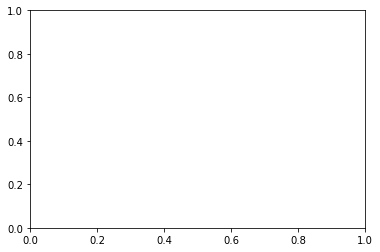

In [25]:
f1_scores = []
best_score = 0
best_n_est = 0
best_clf = None
for i in tqdm(range(50, 1001, 50)):
    clf = CatBoostClassifier(iterations = i)
    clf.fit(train_data)
    y_pred = clf.predict(test_data)
    score = f1_score(y_test, y_pred)
    if best_score < score:
        best_score = score
        best_n_est = i
        best_clf = clf
    f1_scores.append(score)

Text(0.5, 1.0, 'Tuning of n_estimators parameter')

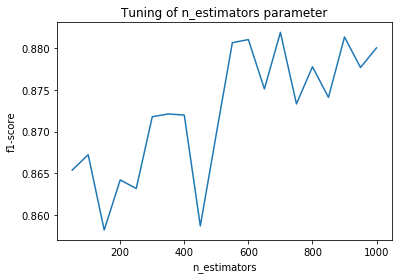

In [26]:
num_est = range(50, 1001, 50)
plt.plot(num_est, f1_scores)
plt.xlabel('n_estimators')
plt.ylabel('f1-score')
plt.title("Tuning of n_estimators parameter")

In [29]:
print("N-estimators={}".format(best_n_est))
y_pred = best_clf.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="catboost"))

N-estimators=700
f1-score=0.9769301753306675
GBM :
             precision    recall  f1-score   support

        0.0    0.95450   0.85637   0.90277      2033
        1.0    0.96453   0.98965   0.97693      8023

avg / total    0.96250   0.96271   0.96194     10056
final score    0.95951   0.92301   0.93985     10056



### lightgbm

In [39]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)

In [47]:
param = {'objective': 'binary', 'metric':'auc'}

f1_scores = []
best_score = 0
best_n_est = 0
best_clf = None

for i in tqdm(range(50, 1001, 50)):
    
    clf = lgb.train(param, train_data, i)
    y_pred = np.where(clf.predict(X_test) < 0.5, 0, 1)
    score = f1_score(y_test, y_pred)
    if best_score < score:
        best_score = score
        best_n_est = i
        best_clf = clf
    f1_scores.append(score)


  5%|████▏                                                                              | 1/20 [00:00<00:02,  6.73it/s]

[LightGBM] [Info] Number of positive: 4123, number of negative: 2970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18975
[LightGBM] [Info] Number of data points in the train set: 7093, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.581277 -> initscore=0.328019
[LightGBM] [Info] Start training from score 0.328019
[LightGBM] [Info] Number of positive: 4123, number of negative: 2970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18975
[LightGBM] [Info] Number of data points in the train set: 7093, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.581277 -> initscore=0.328019
[LightGBM] [Info] Start training from score 0.328019


 10%|████████▎                                                                          | 2/20 [00:00<00:03,  5.44it/s]

[LightGBM] [Info] Number of positive: 4123, number of negative: 2970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18975
[LightGBM] [Info] Number of data points in the train set: 7093, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.581277 -> initscore=0.328019
[LightGBM] [Info] Start training from score 0.328019


 15%|████████████▍                                                                      | 3/20 [00:00<00:04,  4.01it/s]

[LightGBM] [Info] Number of positive: 4123, number of negative: 2970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18975
[LightGBM] [Info] Number of data points in the train set: 7093, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.581277 -> initscore=0.328019
[LightGBM] [Info] Start training from score 0.328019


 20%|████████████████▌                                                                  | 4/20 [00:01<00:05,  3.01it/s]

[LightGBM] [Info] Number of positive: 4123, number of negative: 2970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18975
[LightGBM] [Info] Number of data points in the train set: 7093, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.581277 -> initscore=0.328019
[LightGBM] [Info] Start training from score 0.328019


 25%|████████████████████▊                                                              | 5/20 [00:02<00:06,  2.29it/s]

[LightGBM] [Info] Number of positive: 4123, number of negative: 2970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18975
[LightGBM] [Info] Number of data points in the train set: 7093, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.581277 -> initscore=0.328019
[LightGBM] [Info] Start training from score 0.328019


 30%|████████████████████████▉                                                          | 6/20 [00:02<00:07,  1.87it/s]

[LightGBM] [Info] Number of positive: 4123, number of negative: 2970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18975
[LightGBM] [Info] Number of data points in the train set: 7093, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.581277 -> initscore=0.328019
[LightGBM] [Info] Start training from score 0.328019


 35%|█████████████████████████████                                                      | 7/20 [00:03<00:08,  1.58it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 40%|█████████████████████████████████▏                                                 | 8/20 [00:04<00:08,  1.39it/s]

[LightGBM] [Info] Number of positive: 4123, number of negative: 2970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18975
[LightGBM] [Info] Number of data points in the train set: 7093, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.581277 -> initscore=0.328019
[LightGBM] [Info] Start training from score 0.328019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

 45%|█████████████████████████████████████▎                                             | 9/20 [00:05<00:08,  1.23it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 50%|█████████████████████████████████████████                                         | 10/20 [00:06<00:09,  1.09it/s]

[LightGBM] [Info] Number of positive: 4123, number of negative: 2970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18975
[LightGBM] [Info] Number of data points in the train set: 7093, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.581277 -> initscore=0.328019
[LightGBM] [Info] Start training from score 0.328019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 55%|█████████████████████████████████████████████                                     | 11/20 [00:07<00:08,  1.02it/s]

[LightGBM] [Info] Number of positive: 4123, number of negative: 2970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18975
[LightGBM] [Info] Number of data points in the train set: 7093, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.581277 -> initscore=0.328019
[LightGBM] [Info] Start training from score 0.328019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:09<00:08,  1.03s/it]

[LightGBM] [Info] Number of positive: 4123, number of negative: 2970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18975
[LightGBM] [Info] Number of data points in the train set: 7093, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.581277 -> initscore=0.328019
[LightGBM] [Info] Start training from score 0.328019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:10<00:07,  1.08s/it]

[LightGBM] [Info] Number of positive: 4123, number of negative: 2970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18975
[LightGBM] [Info] Number of data points in the train set: 7093, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.581277 -> initscore=0.328019
[LightGBM] [Info] Start training from score 0.328019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:11<00:06,  1.12s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:12<00:05,  1.16s/it]

[LightGBM] [Info] Number of positive: 4123, number of negative: 2970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18975
[LightGBM] [Info] Number of data points in the train set: 7093, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.581277 -> initscore=0.328019
[LightGBM] [Info] Start training from score 0.328019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:14<00:04,  1.22s/it]

[LightGBM] [Info] Number of positive: 4123, number of negative: 2970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18975
[LightGBM] [Info] Number of data points in the train set: 7093, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.581277 -> initscore=0.328019
[LightGBM] [Info] Start training from score 0.328019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:15<00:03,  1.25s/it]

[LightGBM] [Info] Number of positive: 4123, number of negative: 2970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18975
[LightGBM] [Info] Number of data points in the train set: 7093, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.581277 -> initscore=0.328019
[LightGBM] [Info] Start training from score 0.328019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:16<00:02,  1.28s/it]

[LightGBM] [Info] Number of positive: 4123, number of negative: 2970
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18975
[LightGBM] [Info] Number of data points in the train set: 7093, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.581277 -> initscore=0.328019
[LightGBM] [Info] Start training from score 0.328019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:18<00:01,  1.32s/it]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]


Text(0.5, 1.0, 'Tuning of n_estimators parameter')

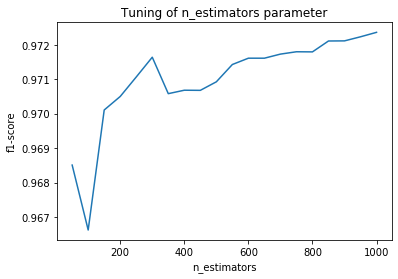

In [48]:
num_est = range(50, 1001, 50)
plt.plot(num_est, f1_scores)
plt.xlabel('n_estimators')
plt.ylabel('f1-score')
plt.title("Tuning of n_estimators parameter")

In [50]:
print("N-estimators={}".format(best_n_est))
y_pred = np.where(best_clf.predict(X_test) < 0.5, 0, 1)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="light gbm"))

N-estimators=1000
f1-score=0.9723618090452262
GBM :
             precision    recall  f1-score   support

        0.0    0.86892   0.92277   0.89504      2033
        1.0    0.98012   0.96473   0.97236      8023

avg / total    0.95764   0.95625   0.95673     10056
final score    0.92452   0.94375   0.93370     10056



### Сравнение качества разных алгоритмов.

*total f1-score* - это f1-score, подсчитанный на всех данных.

*mean f1-score for classes* - это среднее между f1-score для классов спам и неспам.

| Algorithm | total f1-score | mean f1-score for classes |
| --- | --- | --- |
| Logistic regression | 0.9360 | 0.8666 |
| SVM | 0.9585 | 0.9095|
| Perceptron | 0.9389 | 0.8700 |
| Random forest | 0.9656 | 0.9196 |
| Adaboost | 0.9690 | 0.9210 |
| GBM | 0.9698 | 0.9264 |
| xgboost | 0.9670 | 0.9095 |
| dart | 0.9669 | 0.9096 |
| catboost | 0.9769 | 0.93985 |
| Light GBM | 0.9723 | 0.9337 |

catboost показал самые лучшие результаты.

## ЗАДАНИЕ II. ОСНОВНОЕ

In [134]:
def ComputeMyTaskNumber(your_name):
    return 1 + hash(your_name) % 21
ComputeMyTaskNumber("Vakulenko_Yulia")

4


Моё задание - 4. Реализация алгоритма градиентного бустинга с логистической функцией потерь. В качестве базового алгоритма использовать алгоритм CART (задача классификации).

Модель взвешенного голосования:

$$h(x) = \sum_{i=1}^{T}b_i a_i(x), x\in X, b_i\in R $$

Ошибка композиции на обучающей выборке:

$$error = \sum_{j=1}^{N} L(y_j,\sum_{i=1}^{T-1}b_i a_i(x_j) + b a(x_j))$$

Логистическая функция потерь:

$$L(h) = \sum_{j=1}^{N} (-y_j \log f(x_j) - (1 - y_j)\log (1 - f(x_j)))$$

$$f(x_j) = \sigma (h(x_j)) = \frac{1}{1 + \exp^{-h(x_j)}}$$

Рассчитаем антиградиент лосс-функции. Введем обозначение $h(x_j) = h_j $.

Производная сигмоиды:
$$\sigma(h)^{'} = \sigma(h)(1 - \sigma(h))$$

Градиент:
$$\frac{\partial L(y_j, h(x_j))}{\partial h(x_j)} =  \frac{}{\partial h_j} (\sum_{k=1}^{N}(-y_k \log \sigma(h_k)  - (1 - y_k)\log (1 - \sigma(h_j)))) = \frac{}{\partial h(x_j)} (-y_j \log \sigma(h_j) - (1 - y_j)\log (1 - \sigma(h_j))) =  -y_j \frac{\sigma(h_j)(1 - \sigma(h_j))}{\sigma(h_j)} - (1 - y_j)\frac{-\sigma(h_j)(1-\sigma(h_j))}{1-\sigma(h_j)} = -y_j(1 - \sigma(h_j)) + (1 - y_j)\sigma(h_j) = \sigma(h_j) - y_j$$

Антиградиент функции потерь:
$$ -\frac{\partial L(y_j, h(x_j))}{\partial h(x_j)} = y_j - \sigma(h(x_j))$$

Для нахождения коэффициента $b = argmin_b \sum_{j=1}^{N}L(y_j, h_{i-1}(x)+ b a_i(x))$ воспользуемся методом Ньютона.


$$f' = \frac {\partial L}{\partial b} = \sum_{j=1}^{N} a(x_j) (y_j - \sigma (h_{i-1}(x_j) + b a(x_j)))$$
$$f'' = \frac {\partial^2 L}{\partial b^2} = \sum_{j=1}^{N} a^2(x_j) \sigma(1 - \sigma)$$

$$b_k = b_{k-1} - \frac{f'}{f''}$$


In [120]:
from joblib import Parallel, delayed

# Classification and regression tree
class CART():
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        # left child
        self.left = None
        # right child
        self.right = None
        # index of feature that is used to divide samples
        self.feature_idx = -1
        self.feature_threshold = 0
        # value in leaf
        self.value = 0
        self.criterion = 'mse'
    
    def __mse(self, y):
        return ((y - y.mean()) ** 2).sum()
    
    def error(self, y):
        if self.criterion == 'mse':
            return self.__mse(y)
    
    def fit(self, X, y):
        self.value = y.mean()
        
        #print(self.max_depth, self.value)
        
        #stopping criterion
        if self.max_depth < 1:
            return
        
        n_samples = X.shape[0]
        
        best_impurity = None
        error = self.error(y)


        #finding feature for split
        for f in range(X.shape[1]):
            #print(self.feature_idx, best_impurity)
            # indices of samples sorted by value of feature f
            idxs = np.argsort(X[:, f])
            
            # sum of y_true values in fraction of samples
            sum_left = y.sum()
            sum_right = 0

            # number of samples in left and right subtrees
            N_left, N_right = n_samples, 0
            
            #threshold feature's serial number 
            thres = 0
            
            # finding best value of feature f to split 
            while thres < n_samples - 1:
                N_left -= 1
                N_right += 1
                
                # sample with feature index thres
                idx = idxs[thres]
                
                # value of object with idx index
                x = X[idx, f]
                
                sum_left -= y[idx]
                sum_right += y[idx]
                        
                new_error = -((sum_left - sum_left/N_left)**2)/N_left - ((sum_right - sum_right/N_right)**2)/N_right
                
                # equal values of feature
                if thres < n_samples - 1 and x == X[idxs[thres + 1], f]:
                    thres += 1
                    continue

                if self.feature_idx == -1 or new_error < best_impurity:
                    self.feature_idx = f
                    self.feature_threshold = (X[idx, f] + X[idxs[thres + 1], f])/2
                    best_impurity = new_error
                thres += 1
        if self.feature_idx == -1:
            return

        
        # indices for left and right subsamples
        idxs_l = (X[:, self.feature_idx] > self.feature_threshold)
        idxs_r = (X[:, self.feature_idx] <= self.feature_threshold)
    
        #print("feature index = {}, feature threshold = {}".format(self.feature_idx, self.feature_threshold))
        #print("best impurity = {}".format(best_impurity))
        # recursively finds best splits for left and right subtrees
        self.left = CART(self.max_depth - 1)
        self.left.value = y[idxs_l].mean()
        self.right = CART(self.max_depth - 1)
        self.left.value = y[idxs_r].mean()
        
        
    
        self.left.fit(X[idxs_l, :], y[idxs_l])
        self.right.fit(X[idxs_r, :], y[idxs_r])
    
    def update_terminal_regions(self, X, y_true, y_raw):
        
        if self.feature_idx == -1:
            #print('rew')
            #print(self.value)
            
            prob = 1/(1 + np.exp(-y_raw))

            
            residual = y_true - prob
            numerator = np.sum( residual)
            denominator = np.sum((y_true - residual) * (1 - y_true + residual))
            #print(numerator,denominator,numerator / denominator)
            
            if abs(denominator) < 1e-150:
                self.value = 0.0
            else:
                self.value = numerator / denominator
        else:
            idxs_l = (X[:, self.feature_idx] > self.feature_threshold)
            idxs_r = (X[:, self.feature_idx] <= self.feature_threshold)
            
            #mask = X[:, self.feature_idx] > self.feature_threshold
            #self.left.update_terminal_regions(X[mask], y_true[mask], y_raw[mask])
            #self.right.update_terminal_regions(X[~mask], y_true[~mask], y_raw[~mask])
            self.left.update_terminal_regions(X[idxs_l, :], y_true[idxs_l], y_raw[idxs_l])
            self.right.update_terminal_regions(X[idxs_r, :], y_true[idxs_r], y_raw[idxs_r])
            
        
    def __predict(self, x):
        if self.feature_idx == -1:
            return self.value
        
        if x[self.feature_idx] > self.feature_threshold:
            return self.left.__predict(x)
        else:
            return self.right.__predict(x)
        
    def predict(self, X):
        y = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            y[i] = self.__predict(X[i])
            
        return y


In [170]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean_squared_error(y_test, y_pred)

0.15596654736142965

In [171]:
myclf = CART(max_depth=3)
myclf.fit(X_train, y_train)
y_pred2 = myclf.predict(X_test)
mean_squared_error(y_test, y_pred2)

0.15596654736142965

In [121]:
class GBM:
    
    #threshold for classification
    THR = 0.5
    
    def __init__(self, n_estimators=100, learning_rate=0.01, max_depth=3, base_model=CART, subsampling=False, reweight=False):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.base_model = base_model
        
        # coefficients for estimators
        self.b = []
        # list with estimators
        self.a = []
        
        self.staged_losses = []
        
        self.subsampling = subsampling
        self.reweight = reweight

    # logistic fuction
    def __sigmoid(self, h):
        return 1/(1 + np.exp(-h))

    def __negative_grad(self, y, h):
        return  (y - self.__sigmoid(h))
    
    def __log_loss(self, y, y_pred):
        
        sigma = self.__sigmoid(y_pred)
        loss = np.sum(-y*np.log(sigma) - (1 - y)*np.log(1-sigma))
        
        return loss

    # deviance like in sklearn  
    # deviance (= 2 * negative log-likelihood).
    #https://github.com/scikit-learn/scikit-learn/blob/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/ensemble/_gb_losses.py
    def __loss(self, y, y_pred):
        
        return -2 * np.mean((y * y_pred) - np.logaddexp(0, y_pred))
    
    def calc_b_i(self, h, a, y):
        b = 0
        f1 = 10
        eps = 0.001

        while np.abs(f1) > eps:
            Hba = h + b * a
            sigma = self.__sigmoid(Hba)
            # first derivative
            f1 = np.sum(a*(sigma - y))
            # second derivative
            f2 = np.sum(a*a*sigma*(1-sigma))
            delta = f1/f2
            b = b - delta

        return b
    
    def fit(self, X, y):
        # initial prediction is set to be zeros
        h = np.zeros(y.shape[0])
        
        for i in tqdm(range(self.n_estimators)):
            #print(i)
            # vector with antigradients
            g_i = self.__negative_grad(y, h)
            #print('neg_grad = {}'.format(g_i))
            # i-th estimator
            a_i = self.base_model(max_depth=self.max_depth)

            if self.subsampling:
            # subsampling
                inds = np.random.choice(X.shape[0], int(0.5*X.shape[0]), replace=False)
                a_i.fit(X[inds], g_i[inds])
            else:
                a_i.fit(X, g_i)
            if self.reweight:
                a_i.update_terminal_regions(X, y, h)
            #prediction of i-th estimator
            a_i_pred = a_i.predict(X)
            #print("y_pred={}".format(h))
            #print("y_pred_new={}".format(a_i_pred))
            
            #coefficient for new estimator
            b_i = self.calc_b_i(h, a_i_pred, y) * self.learning_rate
            #print('b_i={}'.format(b_i))
            self.b.append(b_i)
            self.a.append(a_i)
            
            h = h + b_i * a_i_pred
            #print(y, h)
            #print(self.__log_loss(y, h))
            self.staged_losses.append(self.__log_loss(y, h))
        return self
    
    def predict(self, X):
        y_pred_proba = self.predict_proba(X)
        y_pred = np.where(y_pred_proba < self.__class__.THR, 0, 1)
        return y_pred
    
    def predict_proba(self, X):
        y_pred = np.zeros(X.shape[0])
        for i in range(self.n_estimators):
            y_pred = y_pred + self.b[i] * self.a[i].predict(X)
        return self.__sigmoid(y_pred)
        
    def predict_all_steps(self, X):
        y_preds = [None] * self.n_estimators
        y_pred = np.zeros(X.shape[0])
        for i in range(self.n_estimators):
            y_pred = y_pred + self.b[i] * self.a[i].predict(X)
            y_preds[i] = np.where(self.__sigmoid(y_pred) < self.__class__.THR, 0, 1)
        return y_preds
    def staged_decision_function(self, X):
        y_preds = [None] * self.n_estimators
        y_pred = np.zeros(X.shape[0])
        for i in range(self.n_estimators):
            y_pred = y_pred + self.b[i] * self.a[i].predict(X)
            y_preds[i] = y_pred
        return y_preds

In [35]:
def sigmoid(h):
        return 1/(1 + np.exp(-h))

def log_loss(y_true, y_pred):
        
        sigma = sigmoid(y_pred)
        loss = np.sum(-y_true*np.log(sigma) - (1 - y_true)*np.log(1-sigma))
        
        return loss

In [160]:
my_gb0 = GBM(learning_rate=0.1, n_estimators=350, 
                         base_model=CART, max_depth=6)
my_gb0.fit(X_train, y_train)
y_pred_my0 = my_gb0.predict(X_test)
f1_score(y_test, y_pred_my0)

100%|██████████████████████████████████████████████████████████████████████████████| 350/350 [1:16:36<00:00, 13.13s/it]


0.9673129505344271

In [128]:
my_gb = GBM(learning_rate=0.1, n_estimators=350, 
                         base_model=CART, max_depth=6, subsampling=True)
my_gb.fit(X_train, y_train)
y_pred_my = my_gb.predict(X_test)
f1_score(y_test, y_pred_my)

100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [37:42<00:00,  6.47s/it]


0.975

In [126]:
my_gb2 = GBM(learning_rate=0.1, n_estimators=350, 
                         base_model=CART, max_depth=6, subsampling=False, reweight=True)
my_gb2.fit(X_train, y_train)
y_pred_my2 = my_gb2.predict(X_test)
f1_score(y_test, y_pred_my2)

100%|██████████████████████████████████████████████████████████████████████████████| 350/350 [1:13:03<00:00, 12.52s/it]


0.9733483483483484

In [122]:
my_gb3 = GBM(learning_rate=0.1, n_estimators=350, 
                         base_model=CART, max_depth=6, reweight=True, subsampling=True)
my_gb3.fit(X_train, y_train)
y_pred_my3 = my_gb3.predict(X_test)
f1_score(y_test, y_pred_my3)

100%|████████████████████████████████████████████████████████████████████████████████| 350/350 [36:27<00:00,  6.25s/it]


0.9726018769288909

In [133]:
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=350, 
                                 max_depth=6, criterion='mse')
clf.fit(X_train, y_train)
y_pred_sk = clf.predict(X_test)
f1_score(y_test, y_pred_sk)

0.9715827112477261

In [134]:
# log losses for sklearn clf 
sk_train_loglosses = []
sk_test_loglosses = []

for raw_pred in tqdm(clf.staged_decision_function(X_test)):
    sk_test_loglosses.append(log_loss(y_test.reshape(-1,1), raw_pred))

for raw_pred in tqdm(clf.staged_decision_function(X_train)):
    sk_train_loglosses.append(log_loss(y_train.reshape(-1,1), raw_pred))   

350it [00:00, 1799.18it/s]
350it [00:00, 2985.05it/s]


In [161]:
my_train_loglosses0 = my_gb0.staged_losses
my_test_loglosses0 = []


for raw_pred in tqdm(my_gb0.staged_decision_function(X_test)):
    my_test_loglosses0.append(my_gb0._GBM__log_loss(y_test, raw_pred))

100%|██████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3694.10it/s]


In [135]:
# log losses for my clf

my_train_loglosses = my_gb.staged_losses
my_test_loglosses = []


for raw_pred in tqdm(my_gb.staged_decision_function(X_test)):
    my_test_loglosses.append(my_gb._GBM__log_loss(y_test, raw_pred))

100%|██████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3393.58it/s]


In [136]:
my_train_loglosses2 = my_gb2.staged_losses
my_test_loglosses2 = []


for raw_pred in tqdm(my_gb2.staged_decision_function(X_test)):
    my_test_loglosses2.append(my_gb2._GBM__log_loss(y_test, raw_pred))

100%|██████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3443.95it/s]


In [137]:
my_train_loglosses3 = my_gb3.staged_losses
my_test_loglosses3 = []


for raw_pred in tqdm(my_gb3.staged_decision_function(X_test)):
    my_test_loglosses3.append(my_gb3._GBM__log_loss(y_test, raw_pred))

100%|██████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3145.82it/s]


In [129]:
def plot_comp_scores(sk_scores, my_scores, title):
    # Plot for comparison of scores from sklearn and mine clfs
    n = len(sk_scores)
    x = np.arange(1,n+1)
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.plot(x, sk_scores, 'm-', label='sklearn test')
    plt.plot(x, my_scores , 'c-', label='my gbm test')
    plt.plot(x, [s * 1.03 for s in sk_scores], 'm-', linestyle='--')
    plt.plot(x, [s * 0.97 for s in sk_scores], 'm-', linestyle='--')
    plt.legend(loc='best')
    plt.xlabel('Iterations')
    plt.ylabel('score')

    print("sklearn score = {:.4f}".format(sk_scores[-1]))
    print("threshold 3% = {:.4f}..{:.4f}".format(0.97 * sk_scores[-1], 1.03 * sk_scores[-1]))
    print("my score = {:.4f}".format(my_scores[-1]))

In [166]:
def plot_comp_scores_all(start, sk_scores, my_scores0, my_scores, my_scores2, my_scores3, title):
    # Plot for comparison of scores from sklearn and mine clfs
    n = len(sk_scores)
    x = np.arange(1,n+1)
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.plot(x[start:], sk_scores[start:], 'm-', label='sklearn test')
    plt.plot(x[start:], my_scores0[start:] , 'c-', label='my gbm test')
    plt.plot(x[start:], my_scores[start:] , 'r-', label='my gbm test, ss')
    plt.plot(x[start:], my_scores2[start:] , 'g-', label='my gbm test, rw')
    plt.plot(x[start:], my_scores3[start:] , 'b-', label='my gbm test, ss+rw')
    plt.plot(x[start:], [s * 1.03 for s in sk_scores[start:]], 'm-', linestyle='--')
    plt.plot(x[start:], [s * 0.97 for s in sk_scores[start:]], 'm-', linestyle='--')
    plt.legend(loc='best')
    plt.xlabel('Iterations')
    plt.ylabel('score')

    print("sklearn score = {:.4f}".format(sk_scores[-1]))
    print("threshold 3% = {:.4f}..{:.4f}".format(0.97 * sk_scores[-1], 1.03 * sk_scores[-1]))
    print("my score = {:.4f}".format(my_scores0[-1]))
    print("my score ss = {:.4f}".format(my_scores[-1]))
    print("my score rw = {:.4f}".format(my_scores2[-1]))
    print("my score rw+ss = {:.4f}".format(my_scores3[-1]))

sklearn score = 1.1820
threshold 3% = 1.1465..1.2174
my score = 0.0099
my score ss = 0.6608
my score rw = 0.0063
my score rw+ss = 0.8517


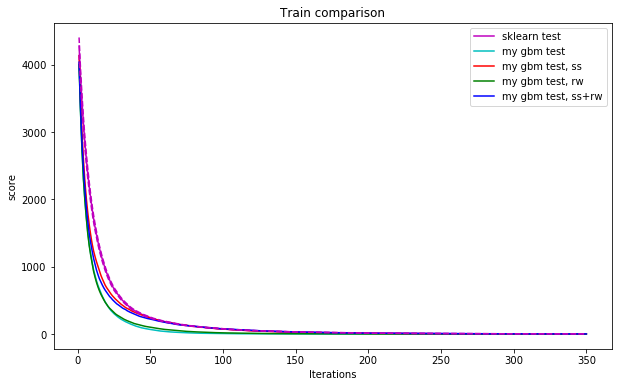

In [169]:
plot_comp_scores_all(0, sk_train_loglosses,my_train_loglosses0, my_train_loglosses, my_train_loglosses2, my_train_loglosses3, "Train comparison")

sklearn score = 1.1820
threshold 3% = 1.1465..1.2174
my score = 0.0099
my score ss = 0.6608
my score rw = 0.0063
my score rw+ss = 0.8517


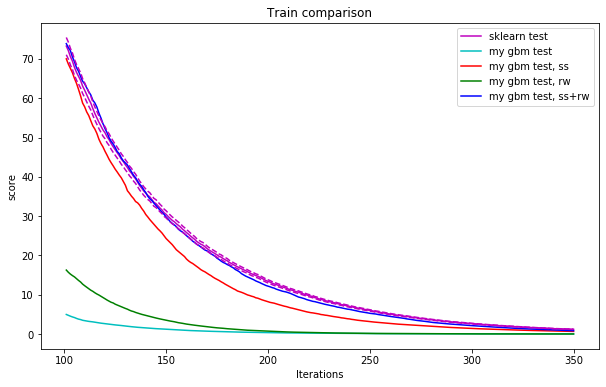

In [168]:
plot_comp_scores_all(100, sk_train_loglosses, my_train_loglosses0, my_train_loglosses, my_train_loglosses2, my_train_loglosses3, "Train comparison")

sklearn score = 1391.8107
threshold 3% = 1350.0564..1433.5651
my score = 2010.1904
my score ss = 1217.4834
my score rw = 1692.2103
my score rw+ss = 1290.5385


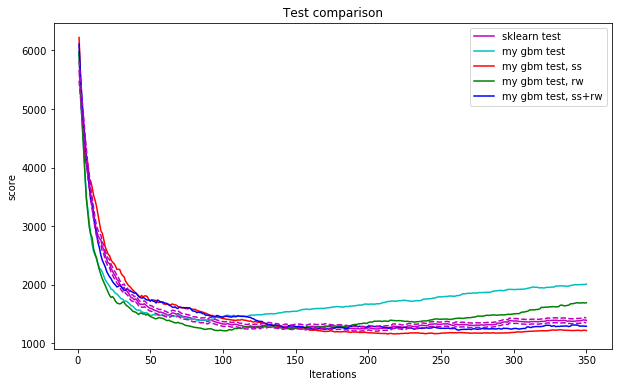

In [167]:
plot_comp_scores_all(0, sk_test_loglosses,my_test_loglosses0, my_test_loglosses, my_test_loglosses2, my_test_loglosses3, "Test comparison")

sklearn score = 1.1820
threshold 3% = 1.1465..1.2174
my score = 0.6608


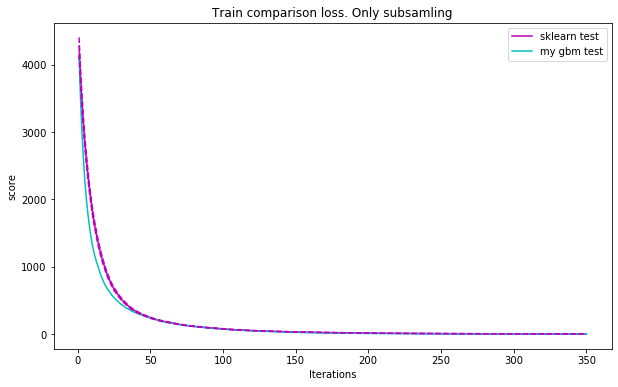

In [151]:
plot_comp_scores(sk_train_loglosses, my_train_loglosses, 'Train comparison loss. Only subsamling')

sklearn score = 1391.8107
threshold 3% = 1350.0564..1433.5651
my score = 1217.4834


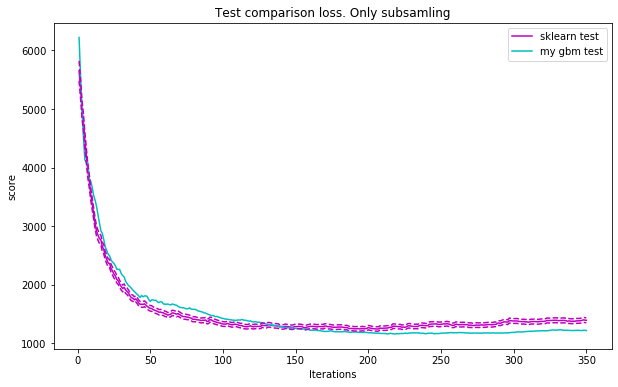

In [152]:
plot_comp_scores(sk_test_loglosses, my_test_loglosses, 'Test comparison loss. Only subsamling')

sklearn score = 1.1820
threshold 3% = 1.1465..1.2174
my score = 0.0063


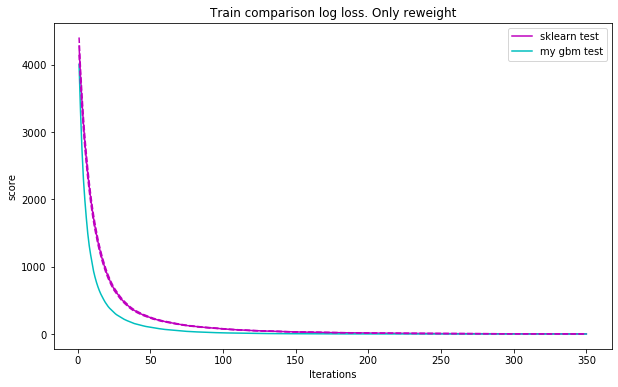

In [153]:
plot_comp_scores(sk_train_loglosses, my_train_loglosses2, 'Train comparison log loss. Only reweight')

sklearn score = 1391.8107
threshold 3% = 1350.0564..1433.5651
my score = 1692.2103


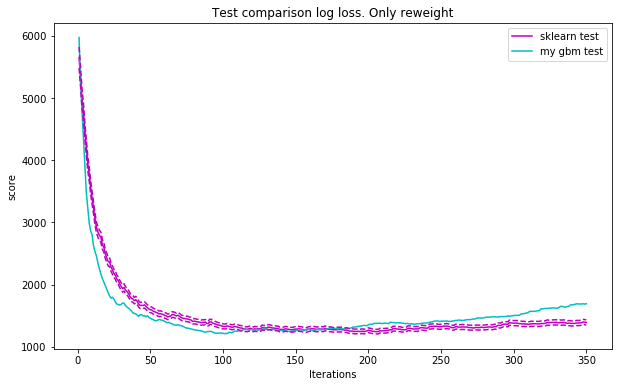

In [154]:
plot_comp_scores(sk_test_loglosses, my_test_loglosses2, 'Test comparison log loss. Only reweight')

sklearn score = 1.1820
threshold 3% = 1.1465..1.2174
my score = 0.8517


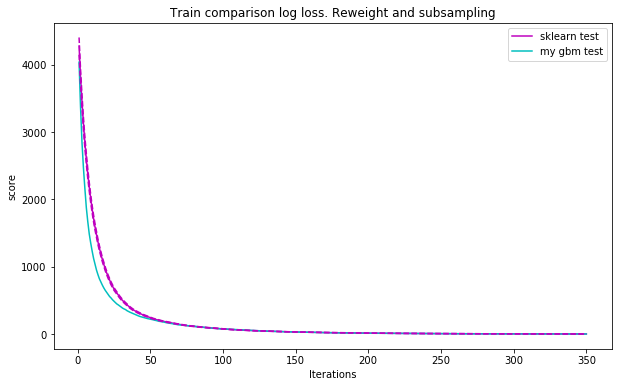

In [155]:
plot_comp_scores(sk_train_loglosses, my_train_loglosses3, 'Train comparison log loss. Reweight and subsampling')

sklearn score = 1391.8107
threshold 3% = 1350.0564..1433.5651
my score = 1290.5385


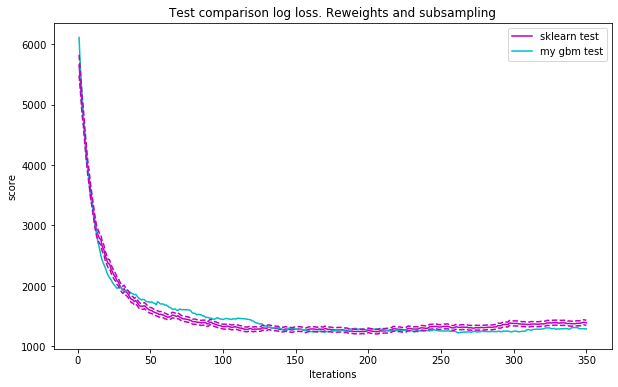

In [156]:
plot_comp_scores(sk_test_loglosses, my_test_loglosses3, 'Test comparison log loss. Reweights and subsampling')